# Кластеризация банков

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# Matplolib default parameters
from matplotlib import rcParams
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

# import warning
import warnings
warnings.filterwarnings('ignore')

# Set option max columns display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import metrics 
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

# %config InlineBackend.figure_format = 'retina'

# sns.set(style='whitegrid', palette='deep')

# plt.rcParams['figure.figsize'] = 8, 5
# plt.rcParams['font.size'] = 12
# plt.rcParams['savefig.format'] = 'pdf'

## Загружаем сырые данные

In [5]:
df_2023 = pd.read_excel('full_dfs/df_2023_full.xlsx')
df_2021 = pd.read_excel('full_dfs/df_2021_full.xlsx')
df_2020 = pd.read_excel('full_dfs/df_2020_full.xlsx')
df_2019 = pd.read_excel('full_dfs/df_2019_full.xlsx')
df_bank_ids = pd.read_excel('full_dfs/bank_ids.xlsx')

In [8]:
df_bank_ids.head()

bank_name      id
0                              Сбербанк     322
1                                   ВТБ     327
2                           Газпромбанк    2764
3                            Альфа-Банк     325
4  НКЦ (Национальный клиринговый центр)  191161

In [9]:
df_2023.head()

bank_name  Вложения в ценные бумаги  \
0                         Сбербанк              6.292502e+09   
1                              ВТБ              4.693619e+09   
2                      Газпромбанк              1.471975e+09   
3                       Альфа-Банк              1.072772e+09   
4  Московский кредитный банк (МКБ)              8.645898e+08   

   Кредитный портфель  Просроченная задолженность в кредитном портфеле  \
0        3.656594e+10                                      155268282.0   
1        1.573751e+10                                      135018281.0   
2        1.024813e+10                                       58494498.0   
3        5.716990e+09                                       23056930.0   
4        3.129535e+09                                       29047964.0   

   Активы нетто    Векселя  Вклады физических лиц  Вложения в акции  \
0   50695718774   77202098            11458178474          45827036   
1   26188218945   44638934             4579261369          83808718   
2   15296029418  106779045             1592032837          26906711   
3    8411400483   22954997             1383959353          28971157   
4    4971033526          0              514246382          20754861   

   Вложения в векселя  Вложения в капиталы других организаций  \
0              580517                              1270984158   
1                   0                              1072255743   
2                   0                               541594156   
3                1000                                15415862   
4                   0                                 8056345   

   Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
0            6246094682    1016170304                       721975229   
1            4609809811     760271572                       189180751   
2            1445068672     364484845                       314108805   
3            1043800235     507862071                       221421881   
4             843834949     497847392                        30659871   

   Высоколиквидные активы  Капитал (по форме 123)  \
0              2837424377              6009350522   
1              1376307864              1708020297   
2              1913602084              1239268046   
3               536528776               837421439   
4               255921811               380444881   

   Кредиты предприятиям и организациям  Кредиты физическим лицам  ЛОРО-счета  \
0                          21633325789               14850451930   339939079   
1                          10617616212                5119891167   173067676   
2                           9512160750                 730273235    74047563   
3                           3558470596                1971280620    56002300   
4                           2865652689                 211538402    92450104   

   НОСТРО-счета  Облигации  Основные средства и нематериальные активы  \
0    1423010926  644773131                                  676395335   
1    1005731610  144541817                                  665718343   
2    1315819277  207329760                                  105302325   
3     378309564  198466884                                   89438361   
4     233877937   30659871                                    9833444   

   Привлеченные МБК  Привлеченные от ЦБ РФ  Прочие активы  \
0        3637628709             1070440895     2036300583   
1        3542435806             1395688627     1882539515   
2        2201819423              479418376      650944656   
3         389493267              138860185      472392973   
4        1173420446               60881212      205249448   

   Размещенные МБК в ЦБ РФ  Средства предприятий и организаций    ФЛ Счета  \
0                        0                         13751643094  3645562530   
1                        0                         11575806309  1925335464   
2                        0                          7964930669  2538942392   
3                   

### Рассчет ROA, ROE для 2021 - 2023 годов

In [10]:
df_2023['ROA'] = df_2023['Чистая прибыль'] / df_2023['Активы нетто']
df_2023['ROE'] = df_2023['Чистая прибыль'] / df_2023['Капитал (по форме 123)']

In [11]:
df_2023 = df_2023.rename(columns = {
                          'Уровень просроченной задолженности по кредитному портфелю' : 'NPL Ratio',
                          'Н2' : 'Н2 liquidity',
                          'Н3' : 'Н3 liquidity',
                          'Н1' : 'Н1 CAR',
                          'Активы нетто': 'Total Assets',
                          'Капитал (по форме 123)' : 'Капитал'})

Создаем дополнительные переменные:
- Банк государственный или частный `gos_sobstv`
- Банк инострынный или отечественный `foreign`
- Банк системнозначимый или не `system`

In [13]:
from clustering_functions import labels_2021_2023
df_2021 = labels_2021_2023(df_2021)
df_2023 = labels_2021_2023(df_2023)

## Собираем осмысленные переменные для кластеризации

### Banks’ risk clustering using k-means: a method based on size and individual & systemic risks
https://drive.google.com/file/d/1FM3AV05f2CrFG5oDe0lKZ3H9cftbDheo/view

The factor called __RatioBS__ measures banks’ exposures using balance sheet ratios, such as: 
- ??? `debt / total assets` <br>
__debt__ = long term borrowings (*Кредиты сроком более 1 года ЮЛ + ФЛ*) + short term borrowings (*Кредиты сроком до 1 года ЮЛ + ФЛ*) + securities sold with repurchase agreements (*Бумаги переданные в РЕПО*). <br>
total assets = *Активы нетто*
- `deposit / total assets` <br>
__deposit__ = total deposits received from customers (*ФЛ Счета + ЮЛ Счета?*)
- `total loans / total assets` - It shows to what extent a bank is engaged in non-classical banking activities. If the value is low, then a bank has a high interbank or trading exposure.<br> 
total loans = *Кредиты физическим лицам + Кредиты предприятиям и организациям + Выданные МБК*. 
- `total loans / deposit` - LDR <br>
LDR > 1 => банк выдает больше кредитов, чем получает в виде депозитов от клиентов. Это может указывать на то, что банк дополнительно финансирует свои кредитные операции через другие источники, такие как межбанковское кредитование или выпуск облигаций.<br>
LDR < 1 => банк получает больше депозитов, чем выдает в виде кредитов. Это может указывать на более консервативную стратегию финансирования и уровень ликвидности банка.
- `non-performing assets / total assets` <br> 
__Non-performing assets__ are composed of non-accrual loans, restructured loans and foreclosed real estate <br>
non-performing assets 
- `non-performing-loans / total loans` <br>
 __non-performing-loans__ =  those in default or close to default. (просрочка) *ФЛ Просроченная задолженность* + *ЮЛ Просроченная задолженность*
- `reserve for loan loss / total loans` 

The __CreditBS__ factor assesses banks’ credit worthiness based on balance
sheet information, such as:
- `common equity / total assets` 
- `ROA` 
- `price / book ratio` = bank’s market capitalization / its common equity.
- `Texas ratio` = bank’s non-performing assets / (reserve for loan loss + total equity). total equity = Капитал по форме 123
- `Z-score` Simple and popular risk measure of a bank’s probability of insolvency.


We also build the __RegCapital__ factor highlighting the main Basel’s capital ratios:
- Tier 1 capital ratio, 
- total risk-based capital ratio, capital adequacy ratio (CAR)
- risk-weighted-asset / total assets. 


### __Украинская статья__ <br>
- `retail loans / revenue generating assets` - A high value of this variable evidences that a bank serves individuals mainly. If the value is low, a bank orients more on
the corporate or wholesale market
- `retail funding / overal liabilities - subordinate debt` - it shows to what extent a bank relies on individuals to fund its operations

- Средняя ставка по кредитам ?
- Средняя ставка по депозитам ?
- Разница между ними ?

credit risk:
- `NPL ratio` - колонка Уровень просроченной задолженности по кредитному портфелю
- `NPL coverage` - колонка Уровень резервирования по кредитному портфелю


### __Using clustering ensemble to identify banking business models__
Делят все показатели на total assets, а сами total assets логарифмируют
- Кредиты предприятиям и организациям / Активы нетто
- Кредиты физическим лицам / Активы нетто
- Выданные МБК / Активы нетто
- (ФЛ Счета + ЮЛ Счета) / Активы нетто
- Привлеченные МБК / Активы нетто
- log(Активы нетто)
- Капитал (по форме 123) / Активы нетто

### Переменные риска

Работа 2 (Иранские банки)<br>

- Показатель LADD - риск ликвидности. Вместо него в нашей работе 2 показателя __H2__ и __H3__ <br>
(LADD = - (Liquidity Asset) / Demand deposit)

- Z-score. __H1__ - минимальная величина собственных средств (капитала) банка, необходимых для покрытия кредитного и рыночного рисков  = total equities / total assets ?<br>
![](https://i.imgur.com/4NpU0FR.png) 
Чем меньше Z-score, тем рискованнее банк


•	`Total Assets / No of branches` – собрать кол-во бранчей для каждого банка (актуально для 2023 года будет, а на предыдущие года можно экстраполировать посчитать в % от отделений 2023) 

https://www.banki.ru/banks/ - ссылка для этого

The Assets/Branches variable shows how intensively the bank uses a chain of branches in its opera􀆟 ons. Since we did not want this variable to implicitly represent banks’ size, we standardized it by assets value. In the results, the variable shows assets’ value per branch. A high value is supposed to indicate a rela􀆟 vely small number of branches.

### Переводим в отрезок [0,1] некоторые показатели:

In [15]:
#процентные колонки
for col in ['Н1','Н2', 'Н3', 'Рентабельность активов-нетто', 'Рентабельность капитала',
       'Уровень обеспечения кредитного портфеля залогом имущества',
        'Уровень просроченной задолженности по кредитному портфелю',
       'Уровень резервирования по кредитному портфелю']:
    df_2019[col] = df_2019[col] / 100
    df_2020[col] = df_2020[col] / 100
    df_2021[col] = df_2021[col] / 100

df_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity']] = df_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity']] / 100

### Рассчет риск фичи Z-score:

In [16]:
df_roa_2016 = pd.read_excel('full_dfs/roa_2016.xlsx')
df_roa_2016 = df_roa_2016.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2016'})
df_roa_2016['ROA_2016'] = df_roa_2016['ROA_2016'] / 100
df_roa_2016 = df_roa_2016[['bank_name', 'ROA_2016']]

df_roa_2017 = pd.read_excel('full_dfs/roa_2017.xlsx')
df_roa_2017 = df_roa_2017.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2017'})
df_roa_2017['ROA_2017'] = df_roa_2017['ROA_2017'] / 100
df_roa_2017 = df_roa_2017[['bank_name', 'ROA_2017']]

df_roa_2018 = pd.read_excel('full_dfs/roa_2018.xlsx')
df_roa_2018 = df_roa_2018.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2018'})
df_roa_2018['ROA_2018'] = df_roa_2018['ROA_2018'] / 100
df_roa_2018 = df_roa_2018[['bank_name', 'ROA_2018']]

df_roa_2019 = df_2019[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2019'})
df_roa_2020 = df_2020[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2020'})
df_roa_2021 = df_2021[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2021'})
df_roa_2023 = df_2023[['bank_name', 'ROA']].rename(columns = {'ROA' : 'ROA_2023'})

df_stdev_roas = df_roa_2021.merge(
    df_roa_2020, how='outer', on='bank_name').merge(
        df_roa_2019, how='outer', on='bank_name').merge(
            df_roa_2018, how='outer', on='bank_name').merge(
                df_roa_2017, how='outer', on='bank_name').merge(
                    df_roa_2016, how='outer', on='bank_name').merge(
                        df_roa_2023, how='outer', on = 'bank_name')

df_stdev_roas['std_ROA_2019'] = df_stdev_roas[['ROA_2019', 'ROA_2018', 'ROA_2017', 'ROA_2016']].std(axis=1)
df_stdev_roas['std_ROA_2020'] = df_stdev_roas[['ROA_2020', 'ROA_2019', 'ROA_2018', 'ROA_2017']].std(axis=1)
df_stdev_roas['std_ROA_2021'] = df_stdev_roas[['ROA_2021', 'ROA_2020', 'ROA_2019', 'ROA_2018']].std(axis=1)
df_stdev_roas['std_ROA_2023'] = df_stdev_roas[['ROA_2023', 'ROA_2021', 'ROA_2020', 'ROA_2019']].std(axis=1)

In [17]:
df_stdev_roas.head()

bank_name  ROA_2021  ROA_2020  ROA_2019  ROA_2018  \
0                         Сбербанк    0.0350    0.0249    0.0310    0.0326   
1                              ВТБ    0.0143    0.0037    0.0130    0.0177   
2                      Газпромбанк    0.0168    0.0044    0.0099    0.0049   
3                       Альфа-Банк    0.0271    0.0420    0.0190    0.0335   
4  Московский кредитный банк (МКБ)    0.0090    0.0045    0.0219    0.0027   

   ROA_2017  ROA_2016  ROA_2023  std_ROA_2019  std_ROA_2020  std_ROA_2021  \
0    0.0298    0.0229  0.027173      0.004273      0.003321      0.004309   
1    0.0105    0.0081  0.007085      0.004104      0.005837      0.005987   
2    0.0073    0.0066  0.015635      0.002077      0.002524      0.005763   
3    0.0161   -0.0012  0.011855      0.014239      0.012225      0.009747   
4    0.0049   -0.0005  0.008277      0.010015      0.008984      0.008665   

   std_ROA_2023  
0      0.004437  
1      0.004992  
2      0.005716  
3      0.012938  
4      0.007582

In [18]:
df_stdev_roas.isna().sum()

bank_name        0
ROA_2021        24
ROA_2020        19
ROA_2019        42
ROA_2018        15
ROA_2017        22
ROA_2016        26
ROA_2023        12
std_ROA_2019    15
std_ROA_2020    13
std_ROA_2021    15
std_ROA_2023    15
dtype: int64

### Создаем остальные осмысленные переменные для кластеризации:

In [19]:
from clustering_functions import preprocess_data_2019_2021, preprocess_data2023

x_2023 = preprocess_data2023(dataframe = df_2023, df_stdev_roas = df_stdev_roas)
x_2021 = preprocess_data_2019_2021(dataframe = df_2021, df_stdev_roas = df_stdev_roas, year = 2021)
x_2020 = preprocess_data_2019_2021(dataframe = df_2020, df_stdev_roas = df_stdev_roas, year = 2020)
x_2019 = preprocess_data_2019_2021(dataframe = df_2019, df_stdev_roas = df_stdev_roas, year = 2019)

In [24]:
x_2023.head()

Н1 CAR  Н2 liquidity  Н3 liquidity       ROA       ROE  NPL Ratio  \
0  0.1301        0.6492        0.8628  0.027173  0.229236   0.000498   
1  0.0946        0.6091        0.8050  0.007085  0.108624   0.000996   
2  0.1102        0.9013        0.6672  0.015635  0.192985   0.000660   
3  0.1191        0.9542        0.7748  0.011855  0.119078   0.000486   
4  0.1207        0.9083        0.6629  0.008277  0.108149   0.001088   

   Debt/TotalAssets  Deposits/TotalAssets  TotalLoans/TotalAssets       LDR  \
0          0.719662              0.497277                0.739706  1.487513   
1          0.600938              0.616883                0.629969  1.021214   
2          0.669614              0.624800                0.693443  1.109863   
3          0.657411              0.565941                0.717789  1.268312   
4          0.619024              0.565755                0.719174  1.271176   

   LiquidAssetsRatio   Z-score  КредитыЮЛ/TotalAssets  КредитыФЛ/TotalAssets  \
0           0.055970  0.018027               0.426729               0.292933   
1           0.052554  0.010801               0.405435               0.195504   
2           0.125104  0.011589               0.621871               0.047743   
3           0.063786  0.005887               0.423053               0.234358   
4           0.051483  0.009191               0.576470               0.042554   

   ВыданныеМБК/TotalAssets  ПривлеченныеМБК/TotalAssets  Капитал/Активы  \
0                 0.020044                     0.071754        0.118538   
1                 0.029031                     0.135268        0.065221   
2                 0.023829                     0.143947        0.081019   
3                 0.060378                     0.046305        0.099558   
4                 0.100150                     0.236052        0.076532   

   log_TotalAssets  gos_sobstv  foreign  system  
0        24.649107         1.0      0.0     1.0  
1        23.988575         1.0      0.0     1.0  
2        23.450859         1.0      0.0     0.0  
3        22.852854         0.0      0.0     1.0  
4        22.326894         0.0      0.0     1.0

## EDA

In [20]:
list_item = []
for col in x_2023.columns:
    list_item.append([col, x_2023[col].dtype, x_2023[col].isna().sum(), 100*x_2023[col].isna().sum()/len(x_2023[col]), x_2023[col].nunique(), x_2023[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

feature data_type  null_num   null_pct  unique_num  \
0                        Н1 CAR   float64         3   0.884956         325   
1                  Н2 liquidity   float64       109  32.153392         214   
2                  Н3 liquidity   float64        11   3.244838         312   
3                           ROA   float64         0   0.000000         339   
4                           ROE   float64         0   0.000000         339   
5                     NPL Ratio   float64         0   0.000000         131   
6              Debt/TotalAssets   float64         0   0.000000         314   
7          Deposits/TotalAssets   float64         0   0.000000         334   
8        TotalLoans/TotalAssets   float64         0   0.000000         337   
9                           LDR   float64         6   1.769912         332   
10            LiquidAssetsRatio   float64         0   0.000000         339   
11                      Z-score   float64        13   3.834808         326   
12        КредитыЮЛ/TotalAssets   float64         0   0.000000         309   
13        КредитыФЛ/TotalAssets   float64         0   0.000000         285   
14      ВыданныеМБК/TotalAssets   float64         0   0.000000         333   
15  ПривлеченныеМБК/TotalAssets   float64         0   0.000000         149   
16               Капитал/Активы   float64         0   0.000000         339   
17              log_TotalAssets   float64         0   0.000000         339   
18                   gos_sobstv   float64         0   0.000000           2   
19                      foreign   float64         0   0.000000           2   
20                       system   float64         0   0.000000           2   

                                        unique_sample  
0       [0.1301, 0.0946, 0.11019999999999999, 0.1191]  
1                    [0.6492, 0.6091, 0.9013, 0.9542]  
2                     [0.8628, 0.805, 0.6672, 0.7748]  
3   [0.027173093829503024, 0.007084588661399707, 0...  
4   [0.22923600777768044, 0.1086244462819753, 0.19...  
5   [0.0004979099361980524, 0.0009958198723961048,...  
6   [0.71966190836831, 0.6009384377017626, 0.66961...  
7   [0.49727713064656665, 0.6168830233139782, 0.62...  
8   [0.7397064077575002, 0.6299694906953512, 0.693...  
9   [1.4875134249502358, 1.021213855604375, 1.1098...  
10  [0.05596970406217442, 0.05255446607081206, 0.1...  
11  [0.018027449109771814, 0.01080063041788652, 0....  
12  [0.42672885032838215, 0.405434834430662, 0.621...  
13  [0.2929330580399278, 0.19550360327110058, 0.04...  
14  [0.020044499389190177, 0.029031052993588755, 0...  
15  [0.07175415985749092, 0.1352682980633298, 0.14...  
16  [0.11853763330172919, 0.06522094154578255, 0.0...  
17  [24.649107301670405, 23.98857548803712, 23.450...  
18                                         [1.0, 0.0]  
19                                         [0.0, 1.0]  
20                                         [1.0, 0.0]

In [166]:
from clustering_functions import visuals_boxplot, visuals_kdeplot, visuals_violinplot

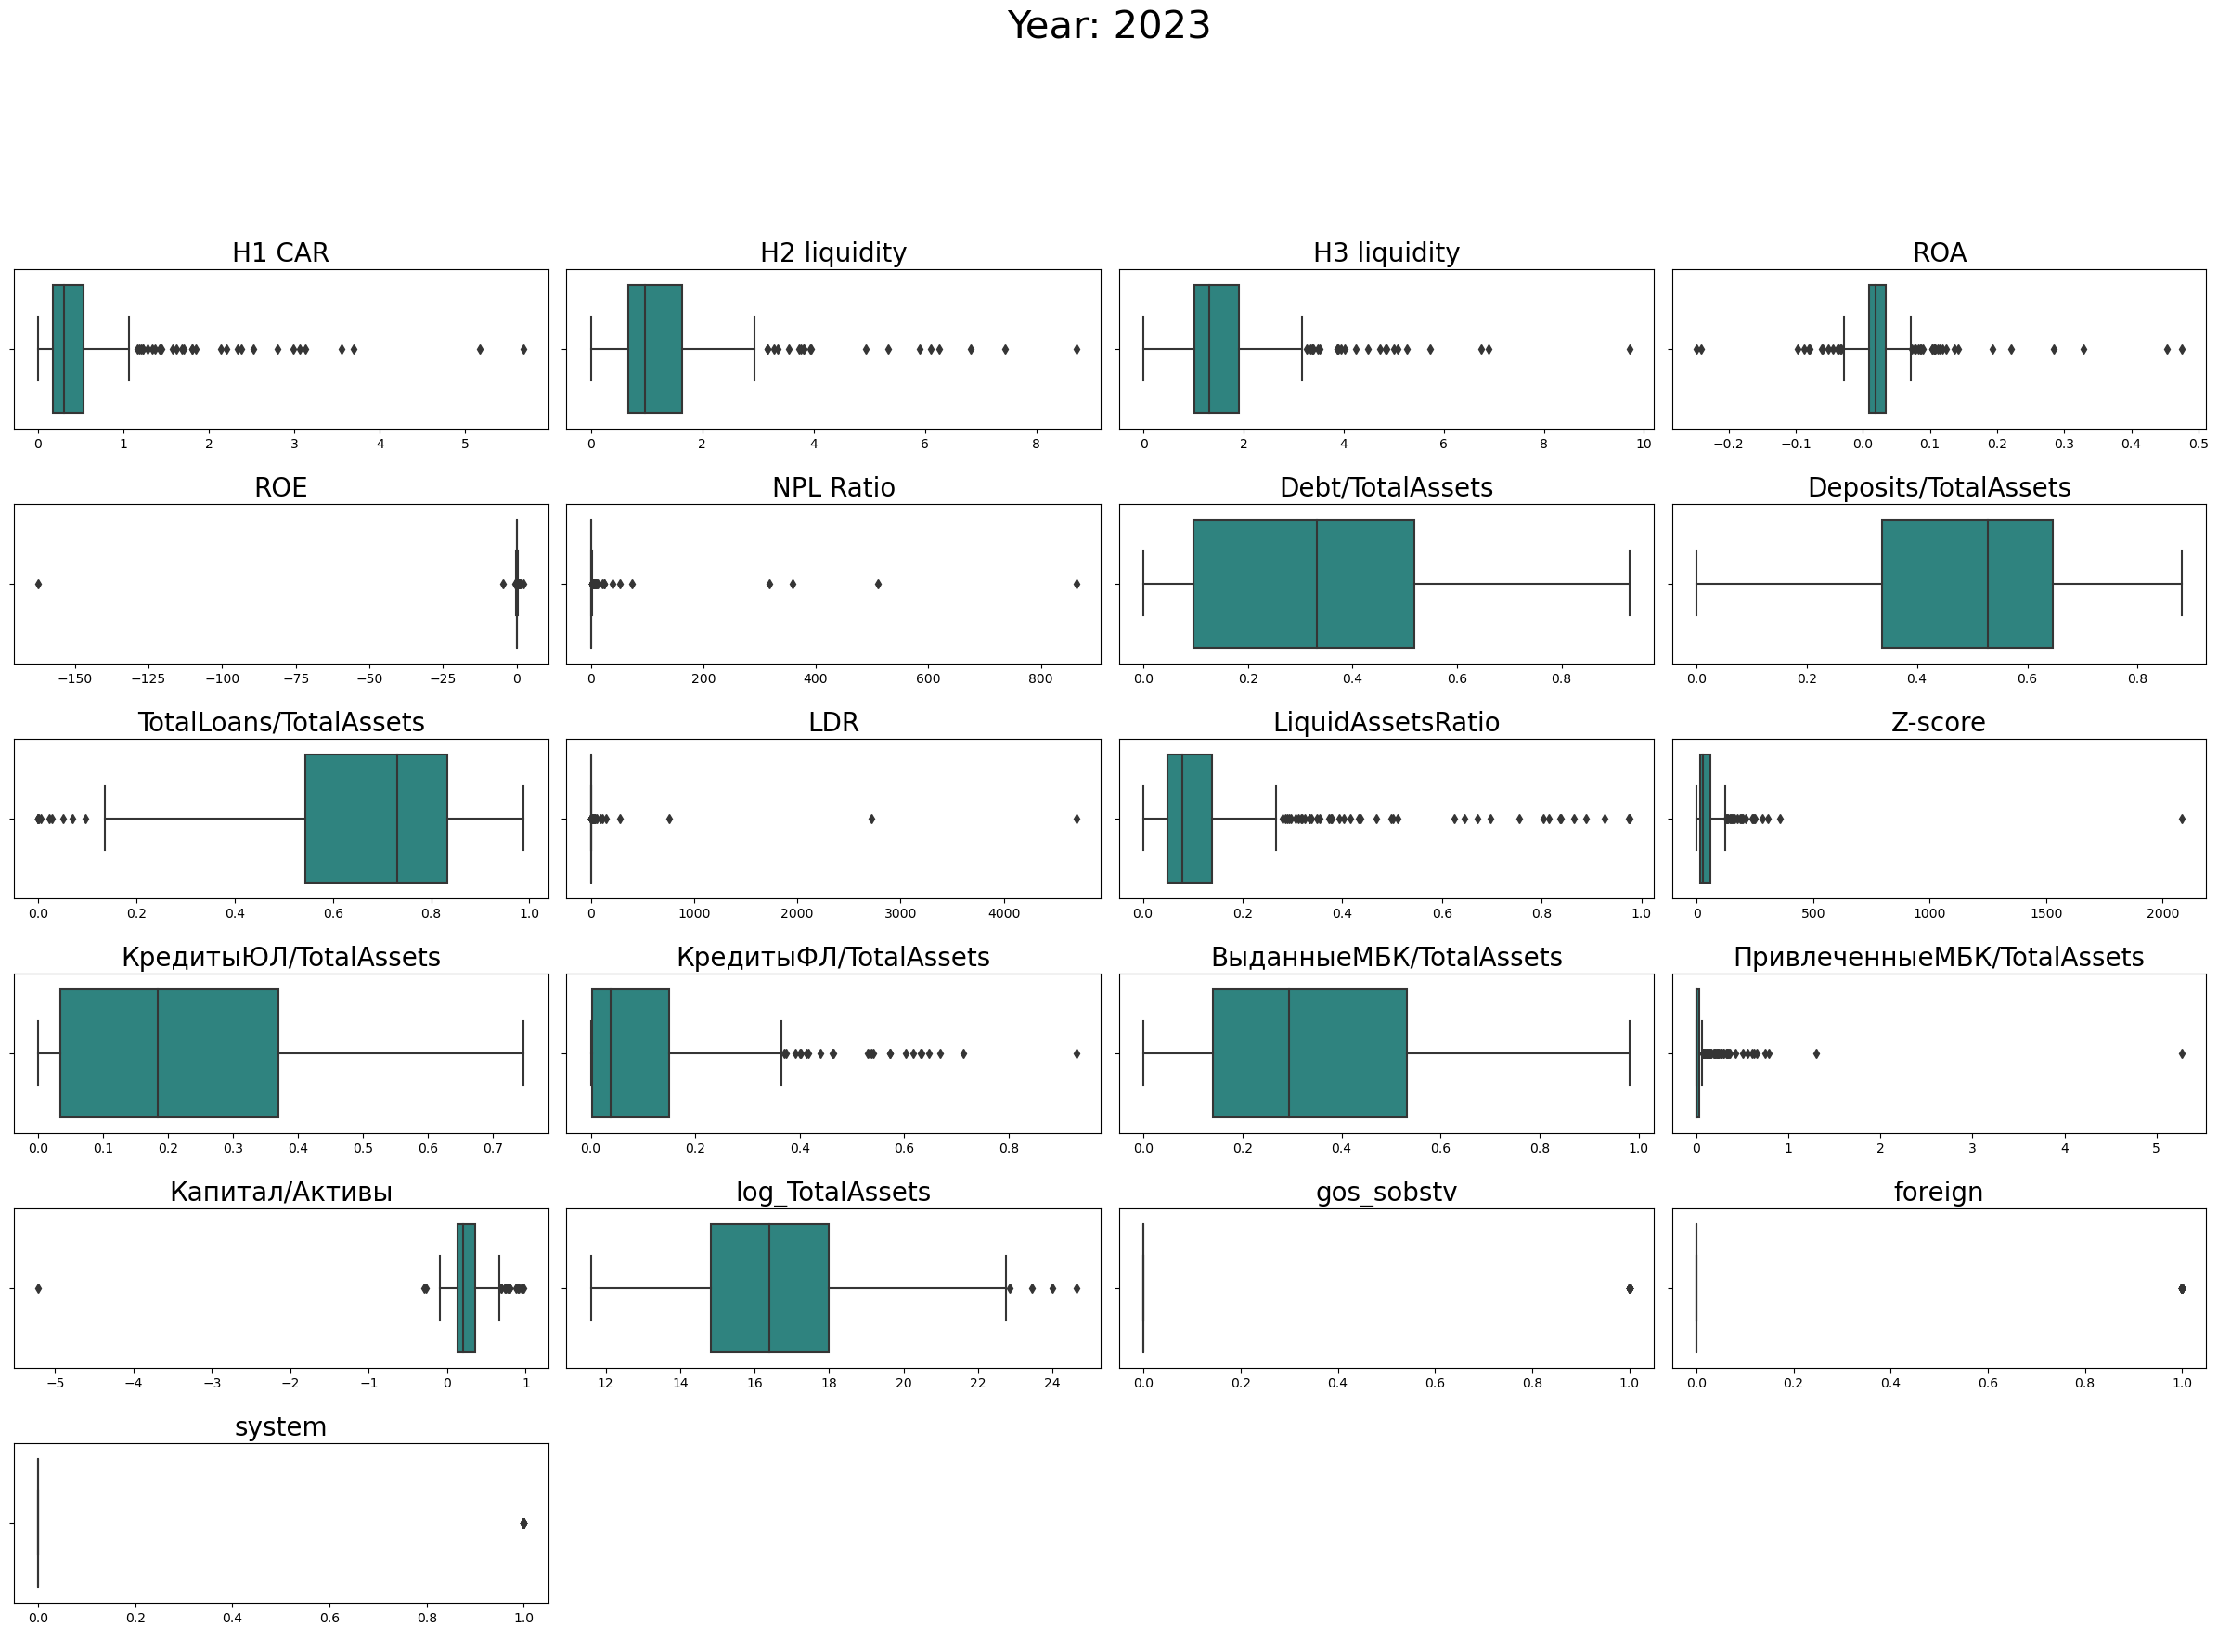

In [99]:
visuals_boxplot(x_2023, year=2023)

- Есть яркие выбросы =>  с ними что-то надо сделать

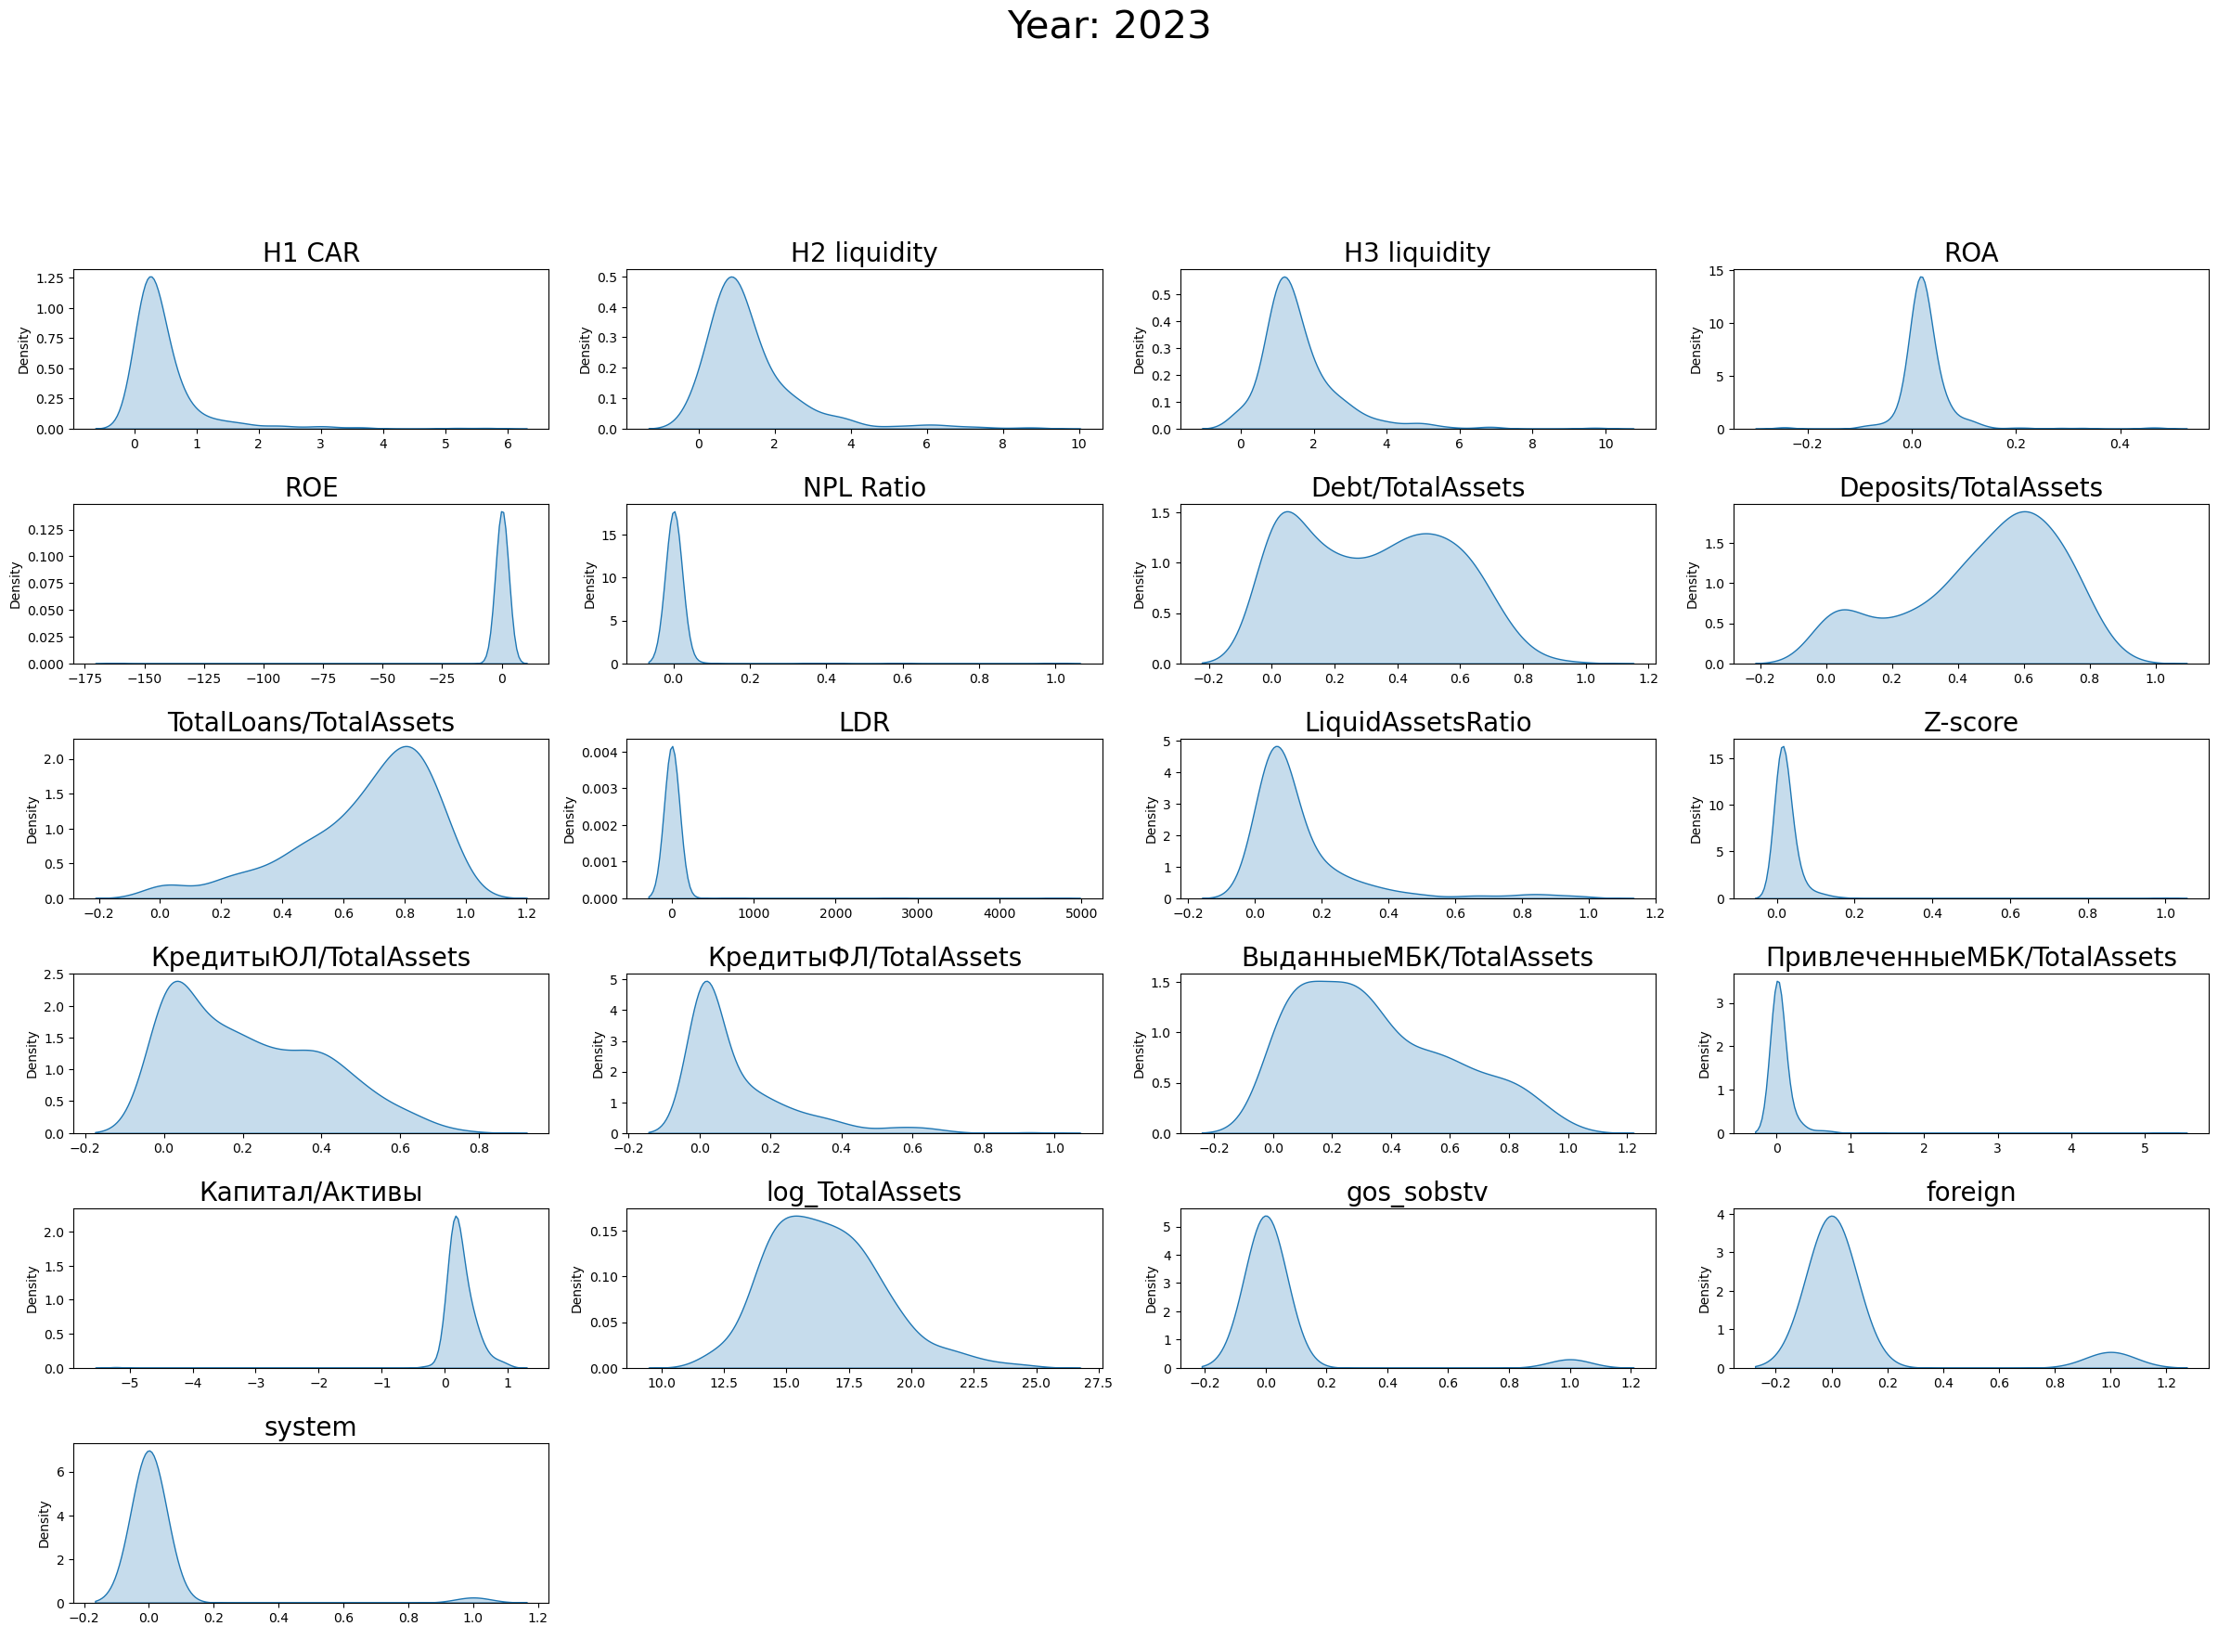

In [167]:
visuals_kdeplot(x_2023, year=2023)

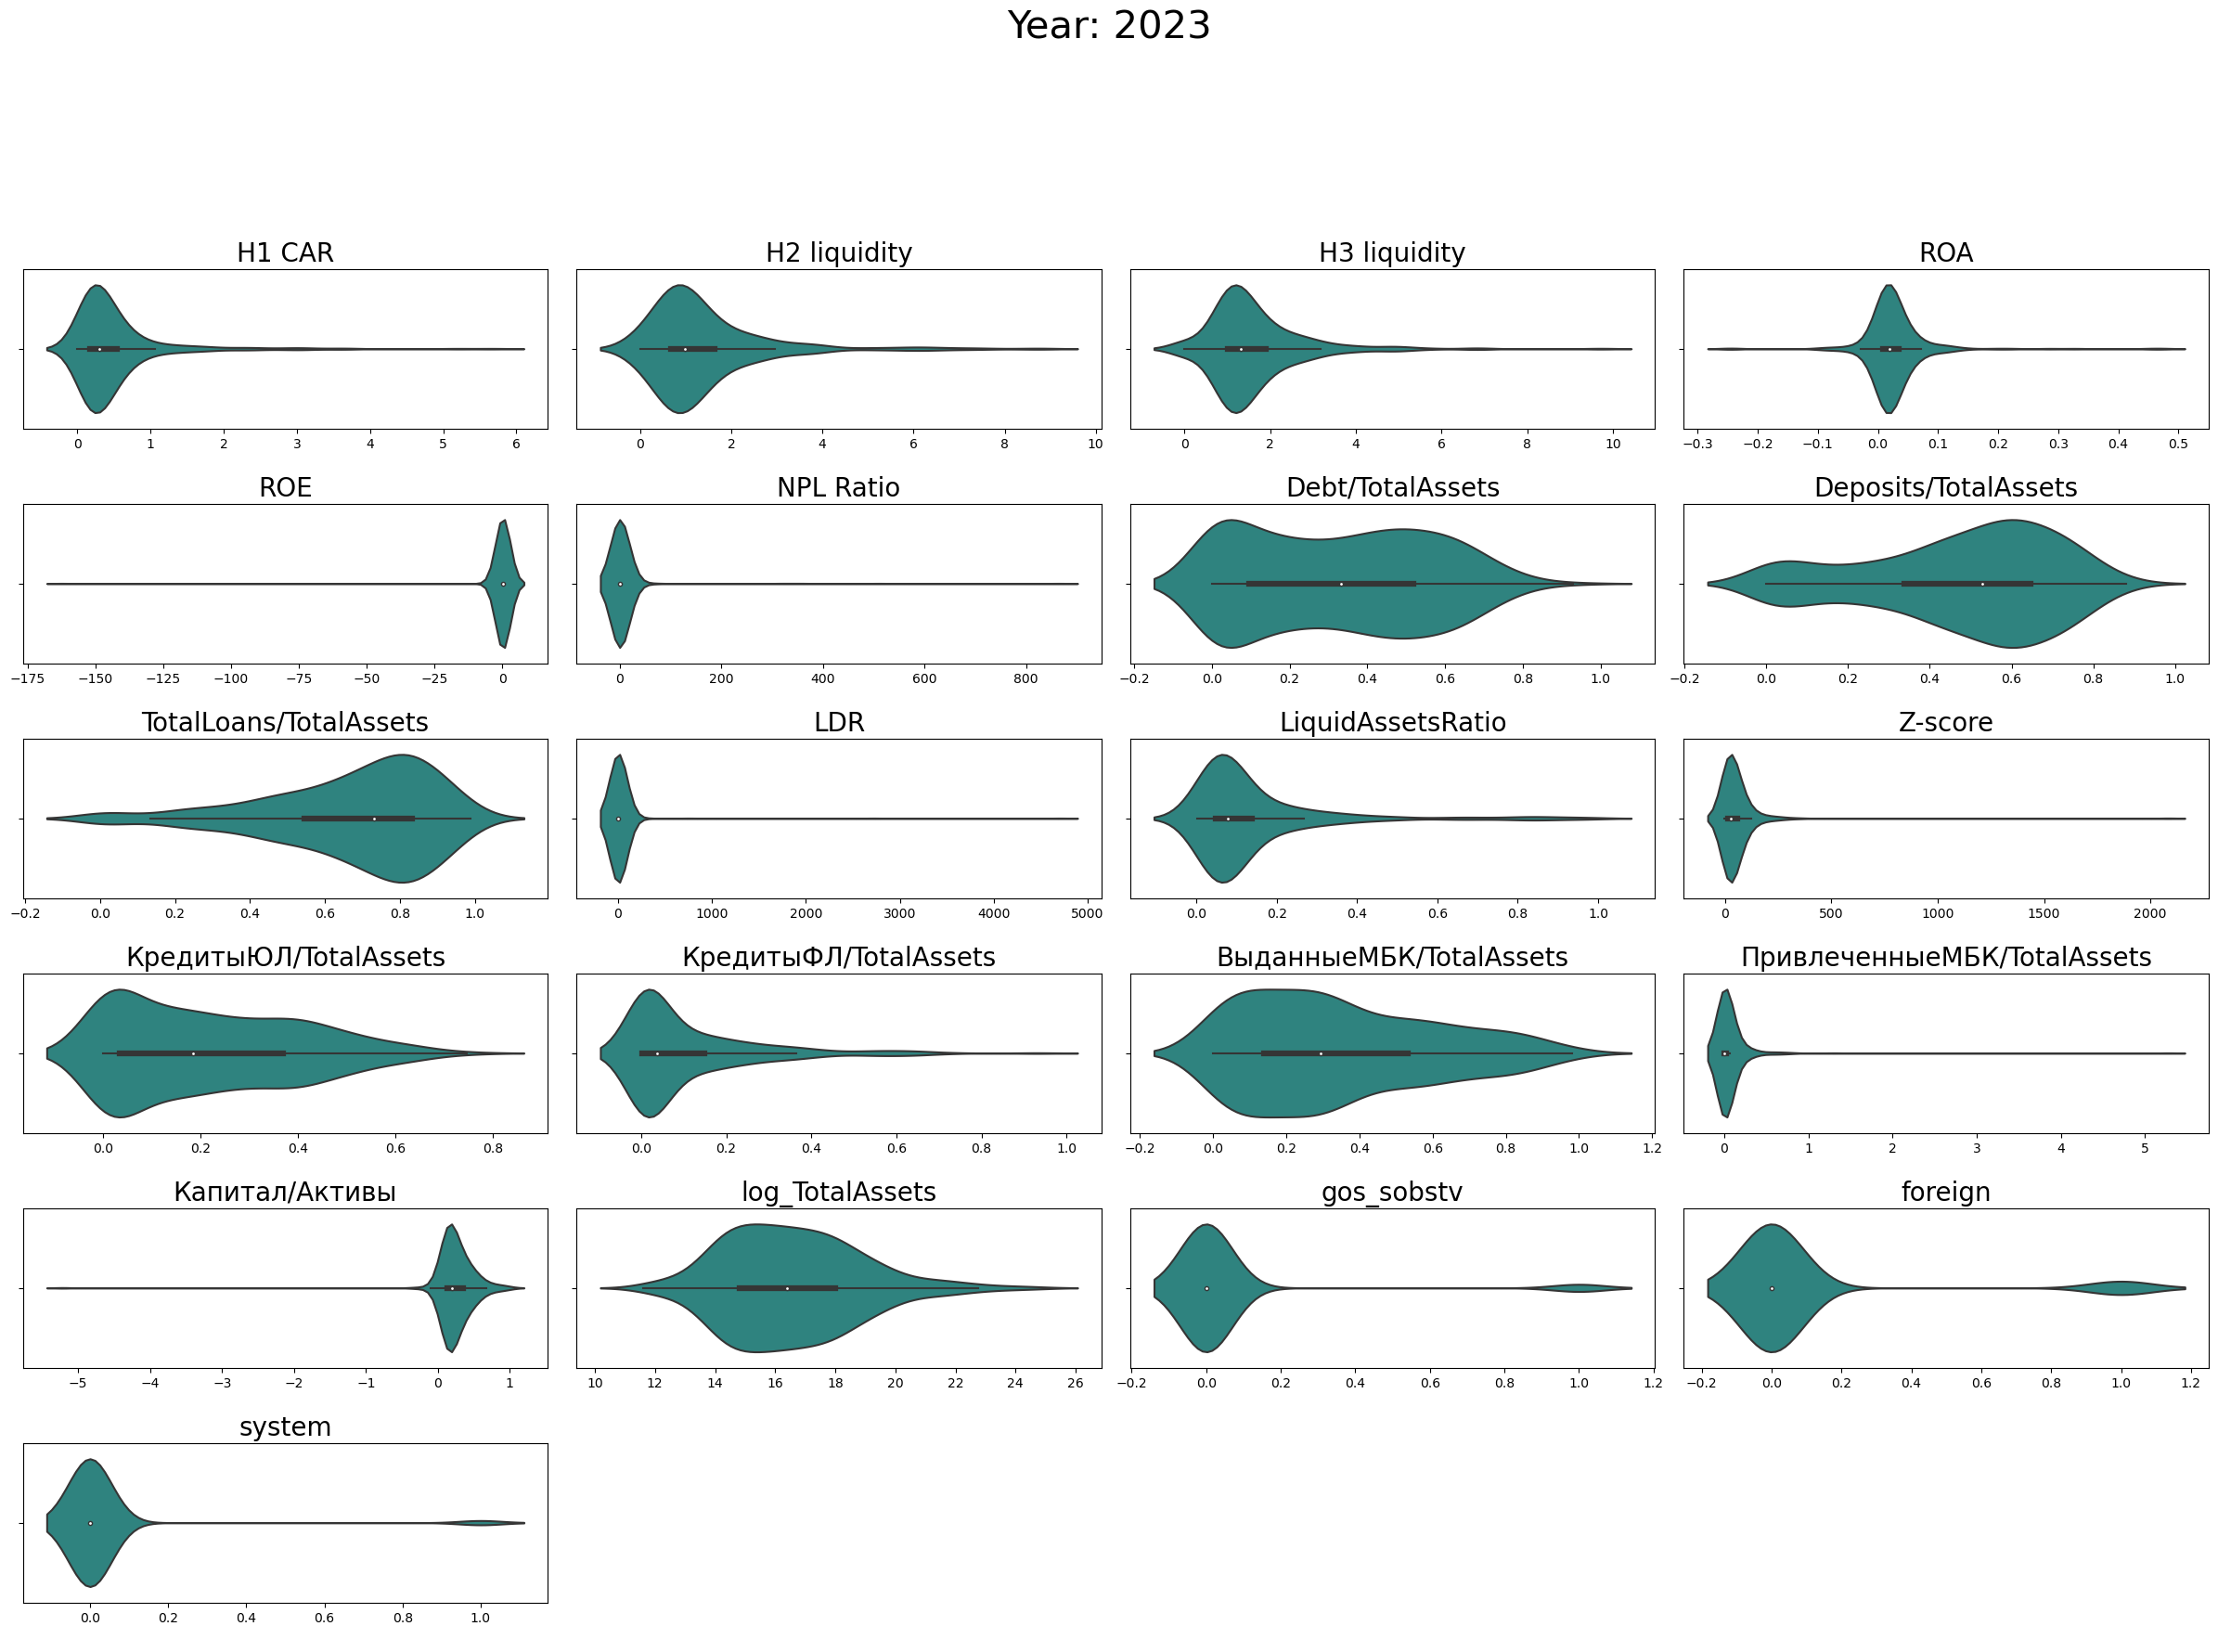

In [101]:
visuals_violinplot(x_2023, year=2023)

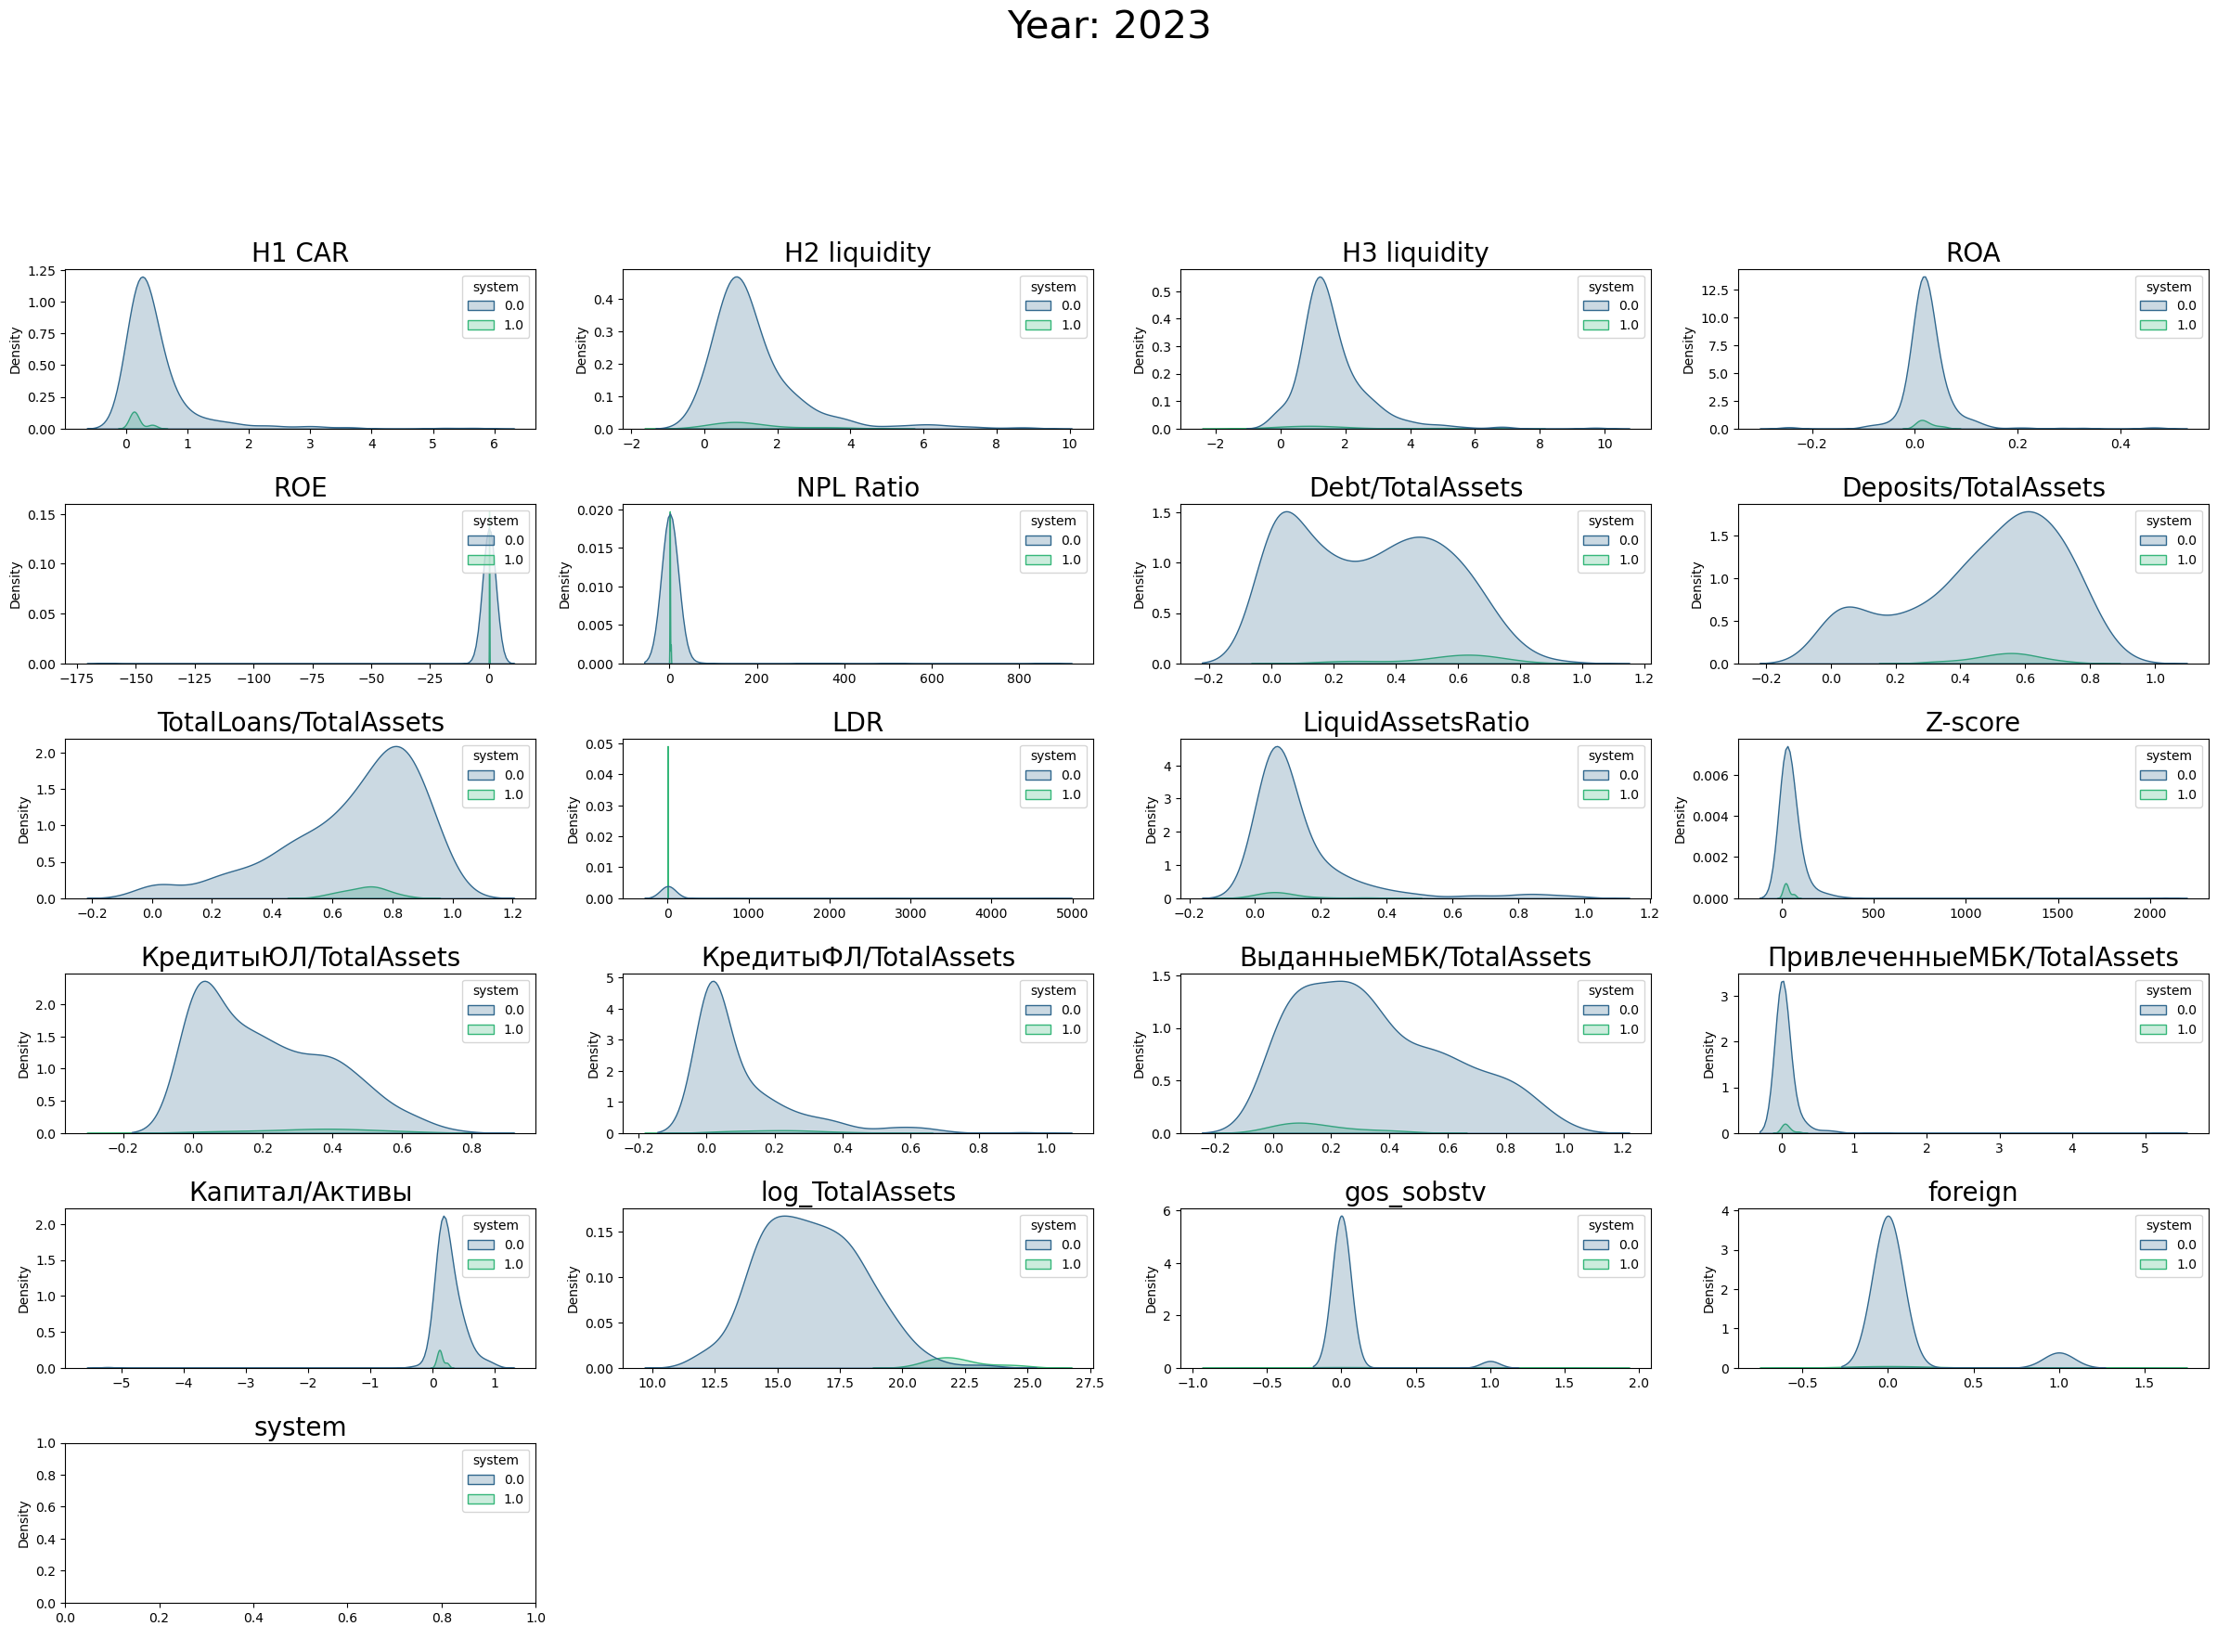

In [102]:
visuals_kdeplot(x_2023, hue= True, hue_col='system', year=2023)

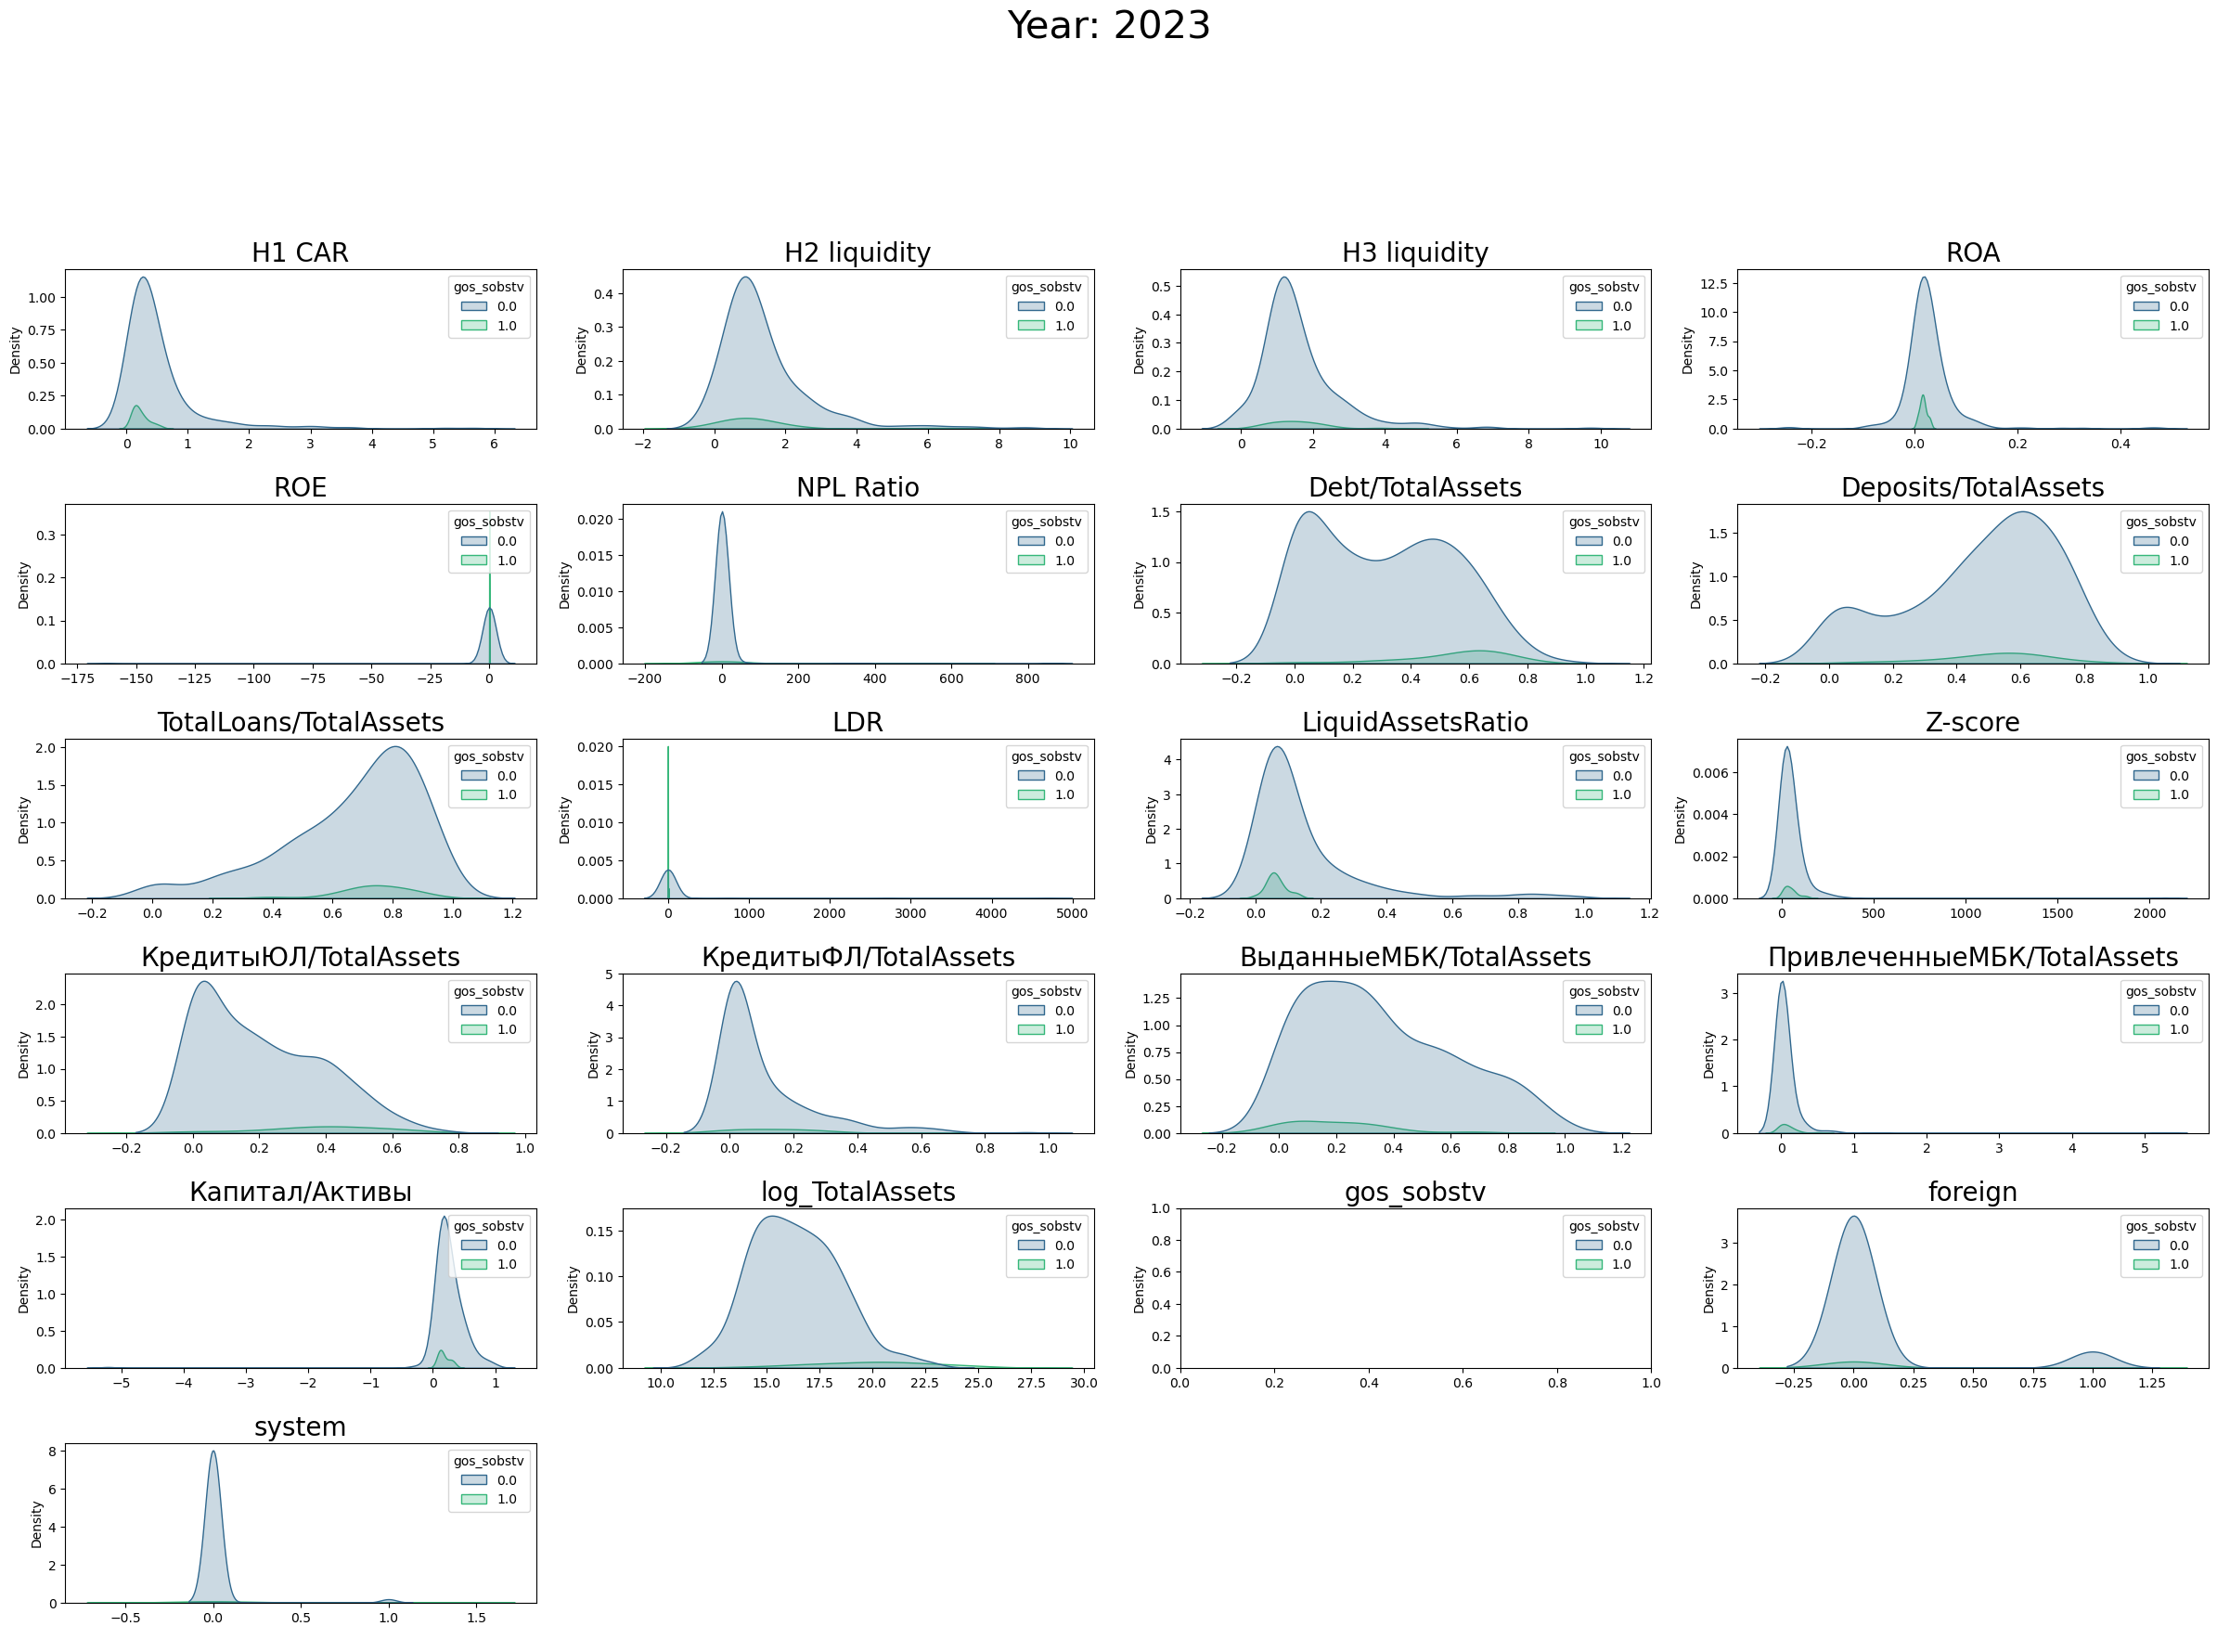

In [103]:
visuals_kdeplot(x_2023, hue= True, hue_col='gos_sobstv', year=2023)

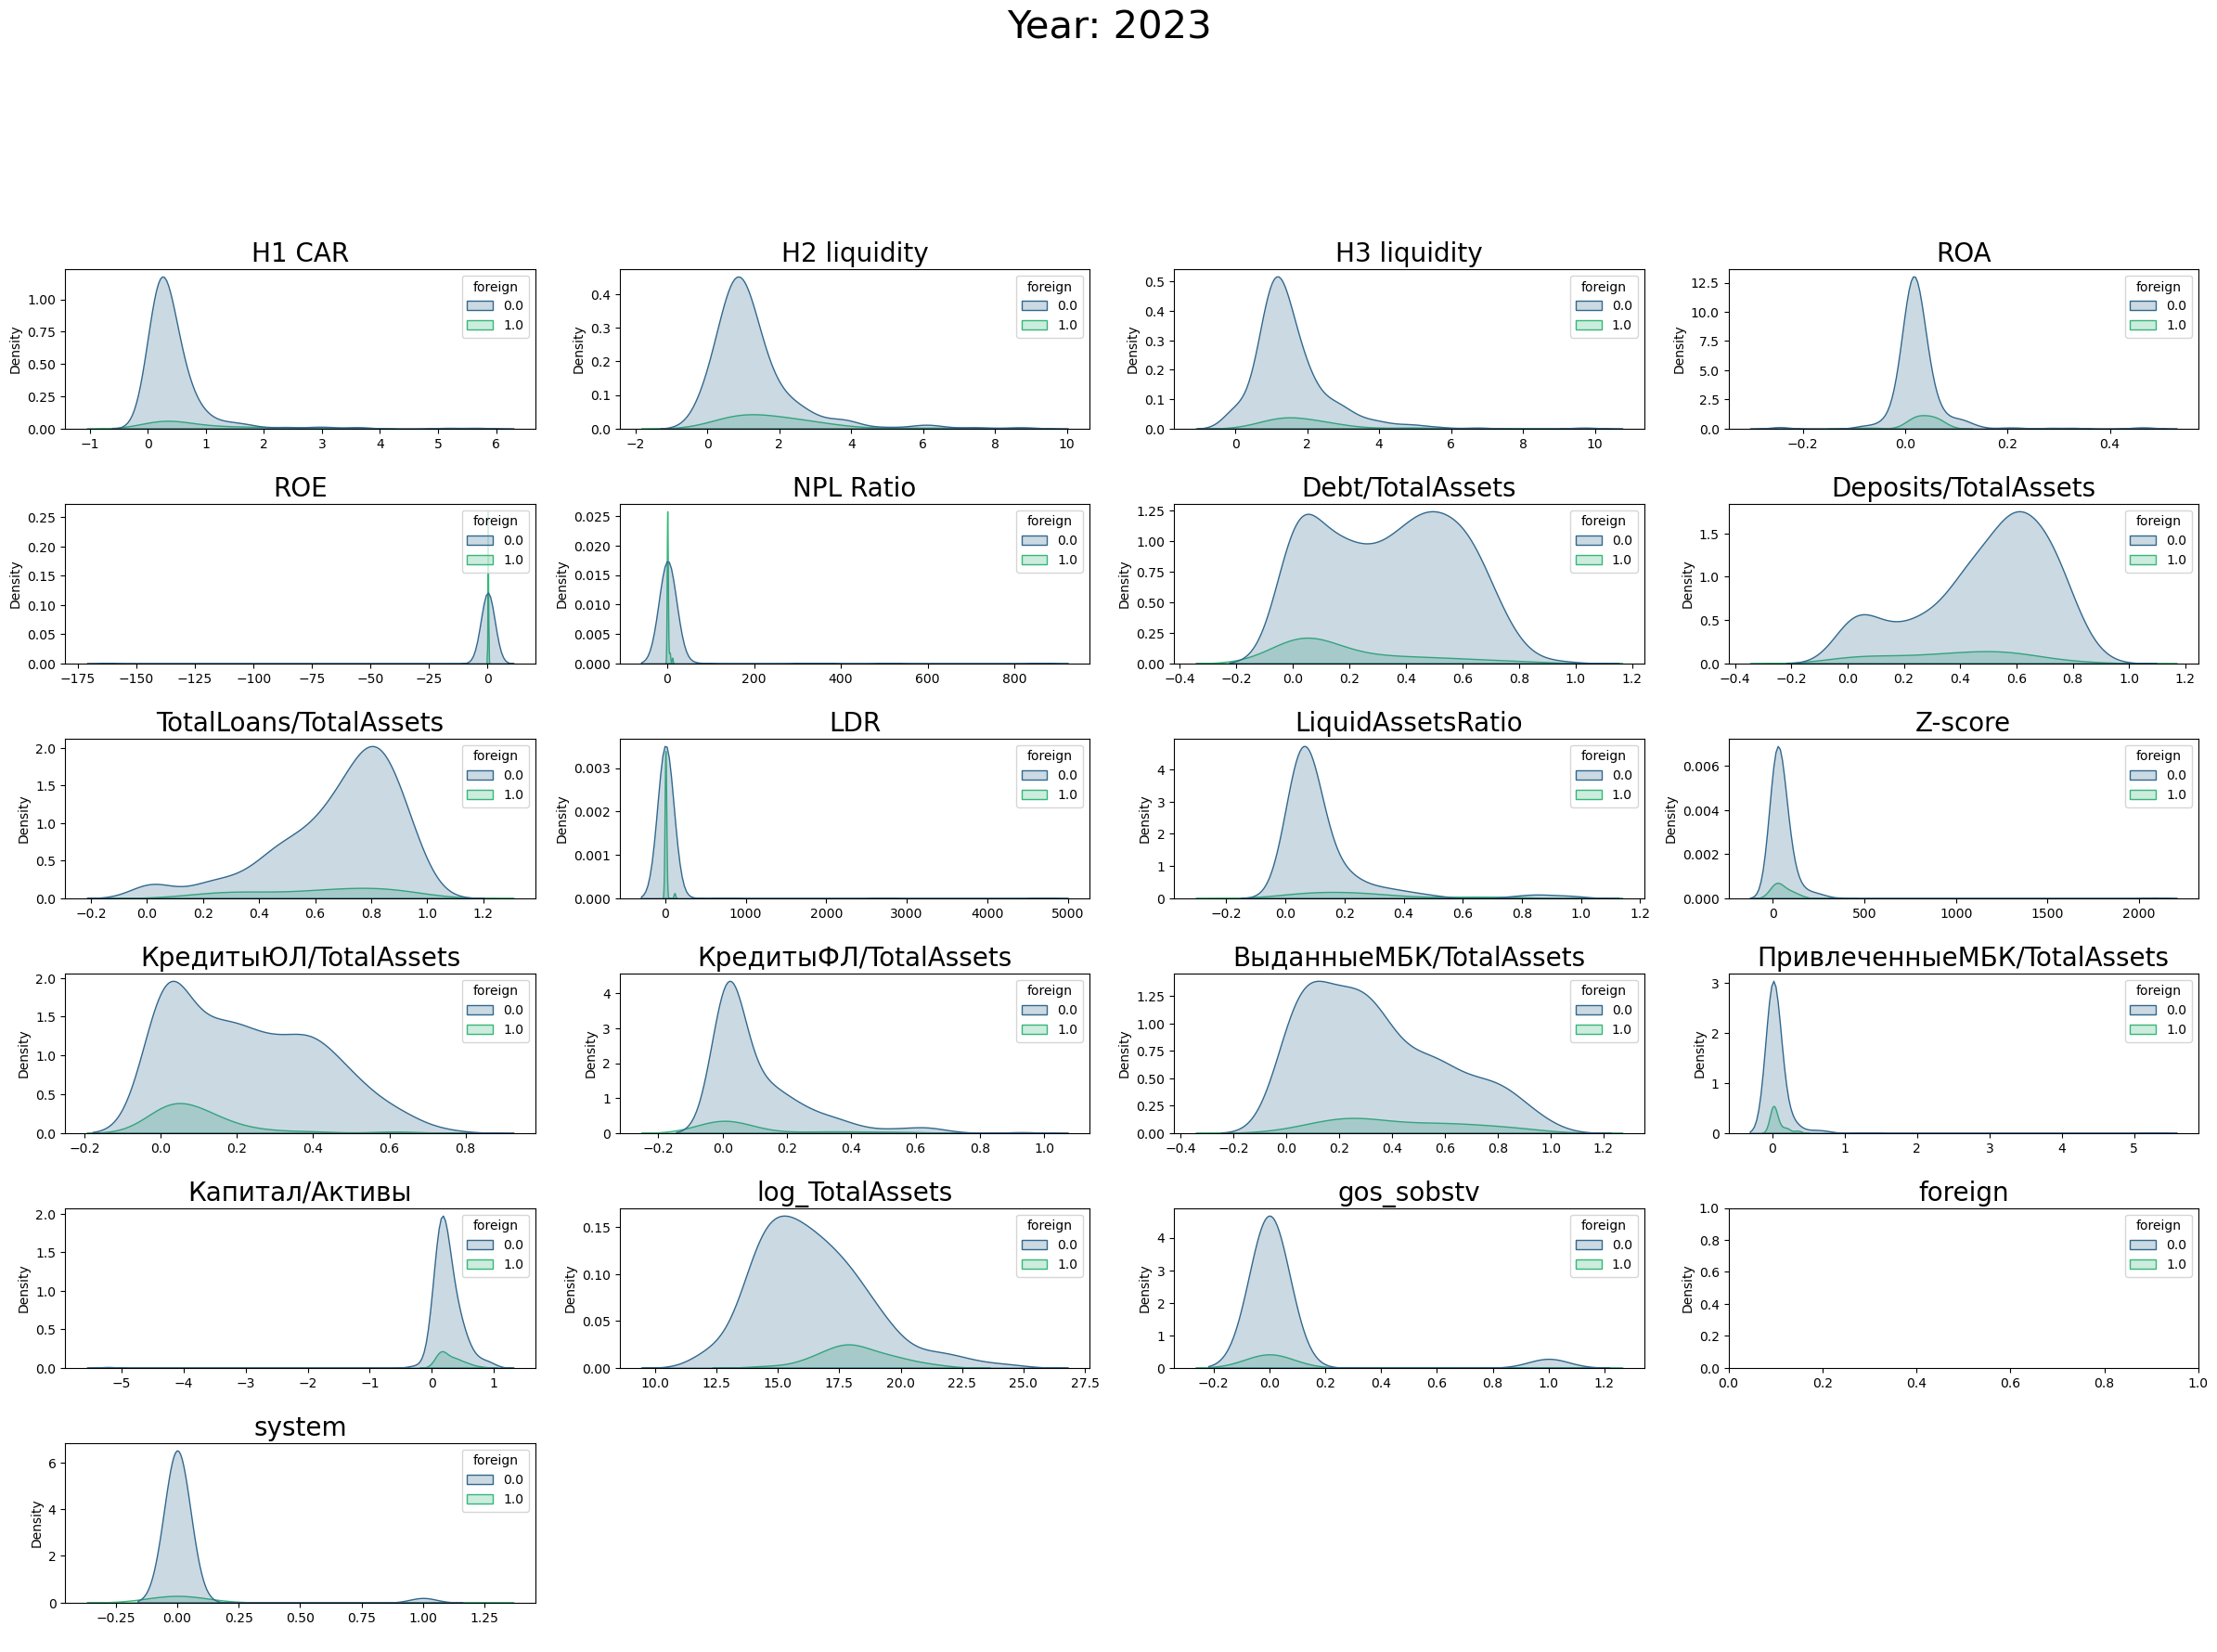

In [104]:
visuals_kdeplot(x_2023, hue= True, hue_col='foreign', year=2023)

In [168]:
def visuals_kdeplot_multiyear(df1, df2, df3, df4, hue = False, hue_col = None):
    plt.figure(figsize=(24,28))
    for i in range(0, df3.shape[1]):
        plt.subplot(10,4,i+1)
         
        sns.kdeplot(x=df1[df1.columns[i]], palette='viridis', shade=True, label='2023')
        sns.kdeplot(x=df2[df2.columns[i]], palette='viridis', shade=True, label='2021')
        sns.kdeplot(x=df3[df3.columns[i]], palette='viridis', shade=True, label='2020')
        sns.kdeplot(x=df4[df4.columns[i]], palette='viridis', shade=True, label='2019')
        plt.legend()
        plt.title(df1.columns[i], fontsize=20)
        plt.xlabel(' ')
        plt.tight_layout()
        plt.suptitle('Межгодовое сравнение', fontsize=30)
        plt.subplots_adjust(top=0.88)

In [18]:
x_2023['LTV'] = None
x_2023['NPL Coverage'] = None
x_2023['NPL/TotalLoans'] = None
x_2023 = x_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity', 'ROA', 'ROE', 'LTV',
       'NPL Ratio', 'NPL Coverage', 'Debt/TotalAssets', 'Deposits/TotalAssets',
       'TotalLoans/TotalAssets', 'LDR', 'NPL/TotalLoans', 'LiquidAssetsRatio',
       'Z-score', 'КредитыЮЛ/TotalAssets', 'КредитыФЛ/TotalAssets',
       'ВыданныеМБК/TotalAssets', 'ПривлеченныеМБК/TotalAssets',
       'Капитал/Активы', 'log_TotalAssets', 'gos_sobstv', 'foreign', 'system']]

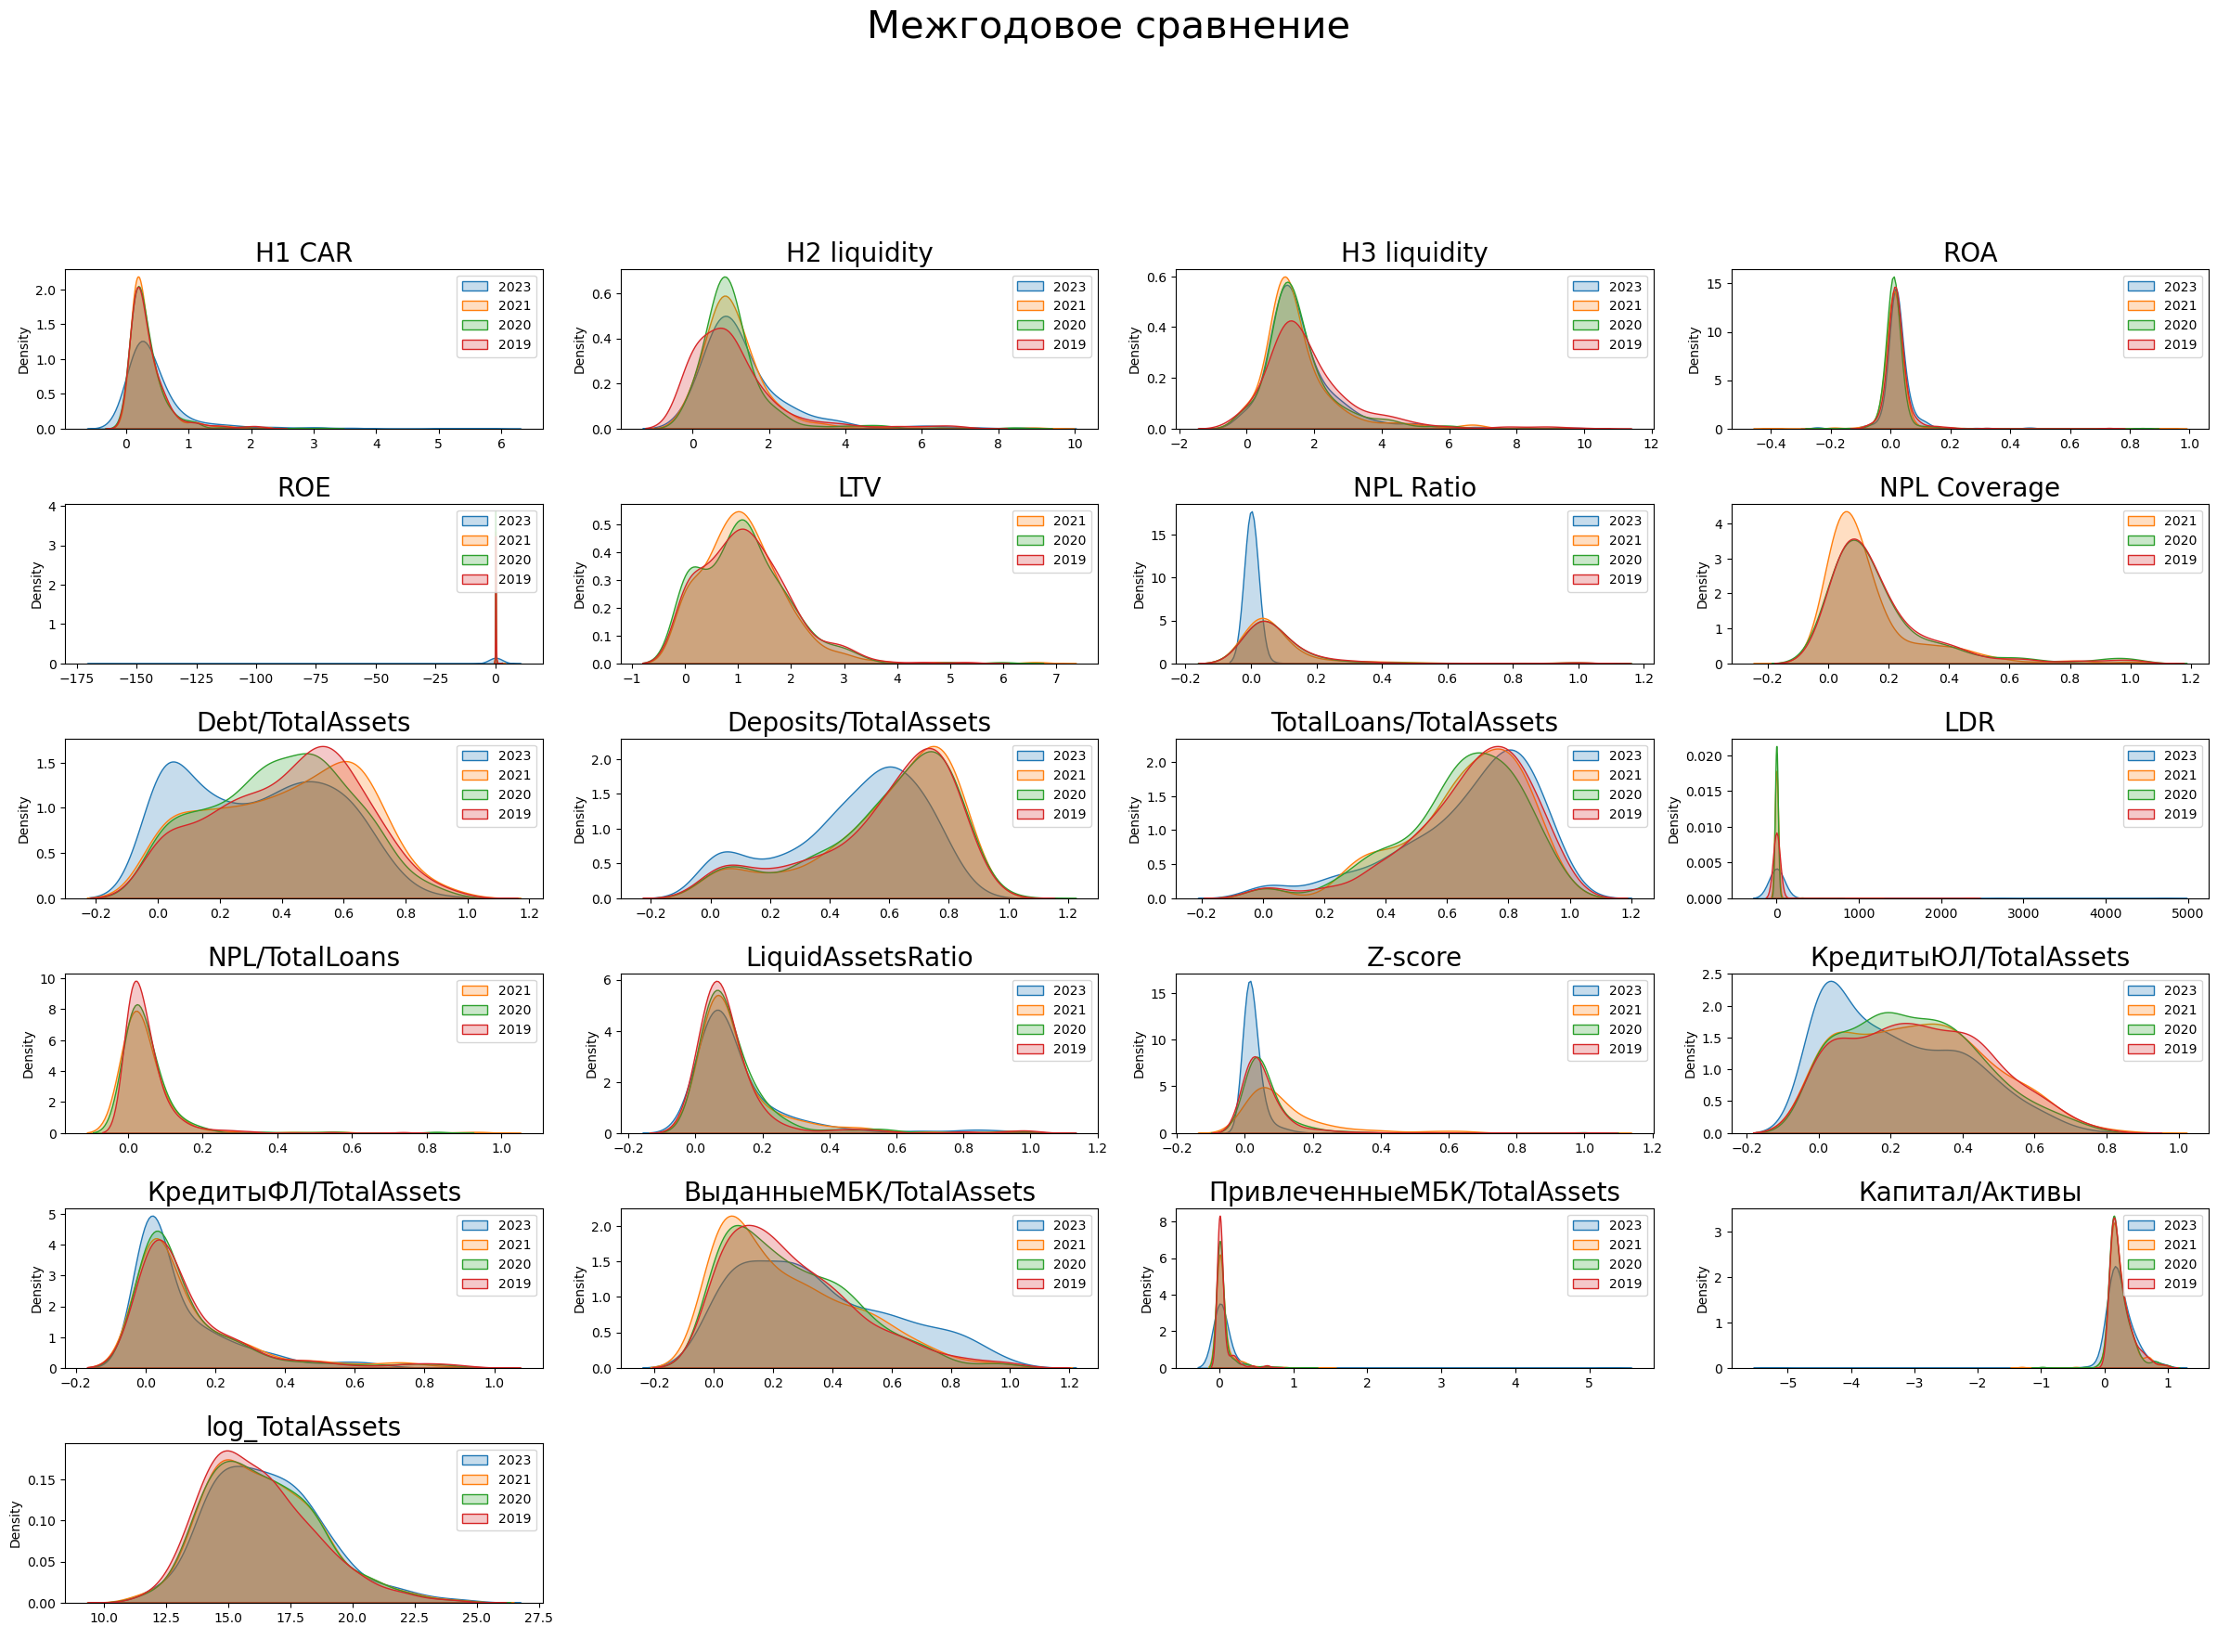

In [170]:
visuals_kdeplot_multiyear(x_2023, x_2021, x_2020, x_2019)

Переводим Z-score в отрезок [0,1]:

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_scaled = scaler.fit_transform(x_2023[['Z-score']])
x_2023['Z-score'] = feature_scaled

In [162]:
x_2023['Z-score'] = feature_scaled

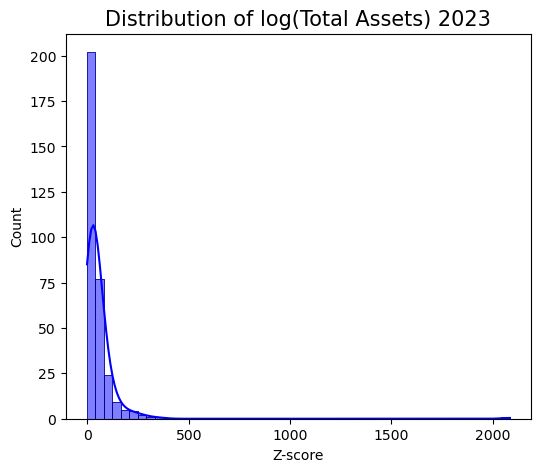

In [68]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Distribution of log(Total Assets) 2023', fontsize=15)
sns.histplot(x_2023['Z-score'],
             bins=50,
             ax=ax,
             color='blue',
             edgecolor='darkblue',
             kde = True);

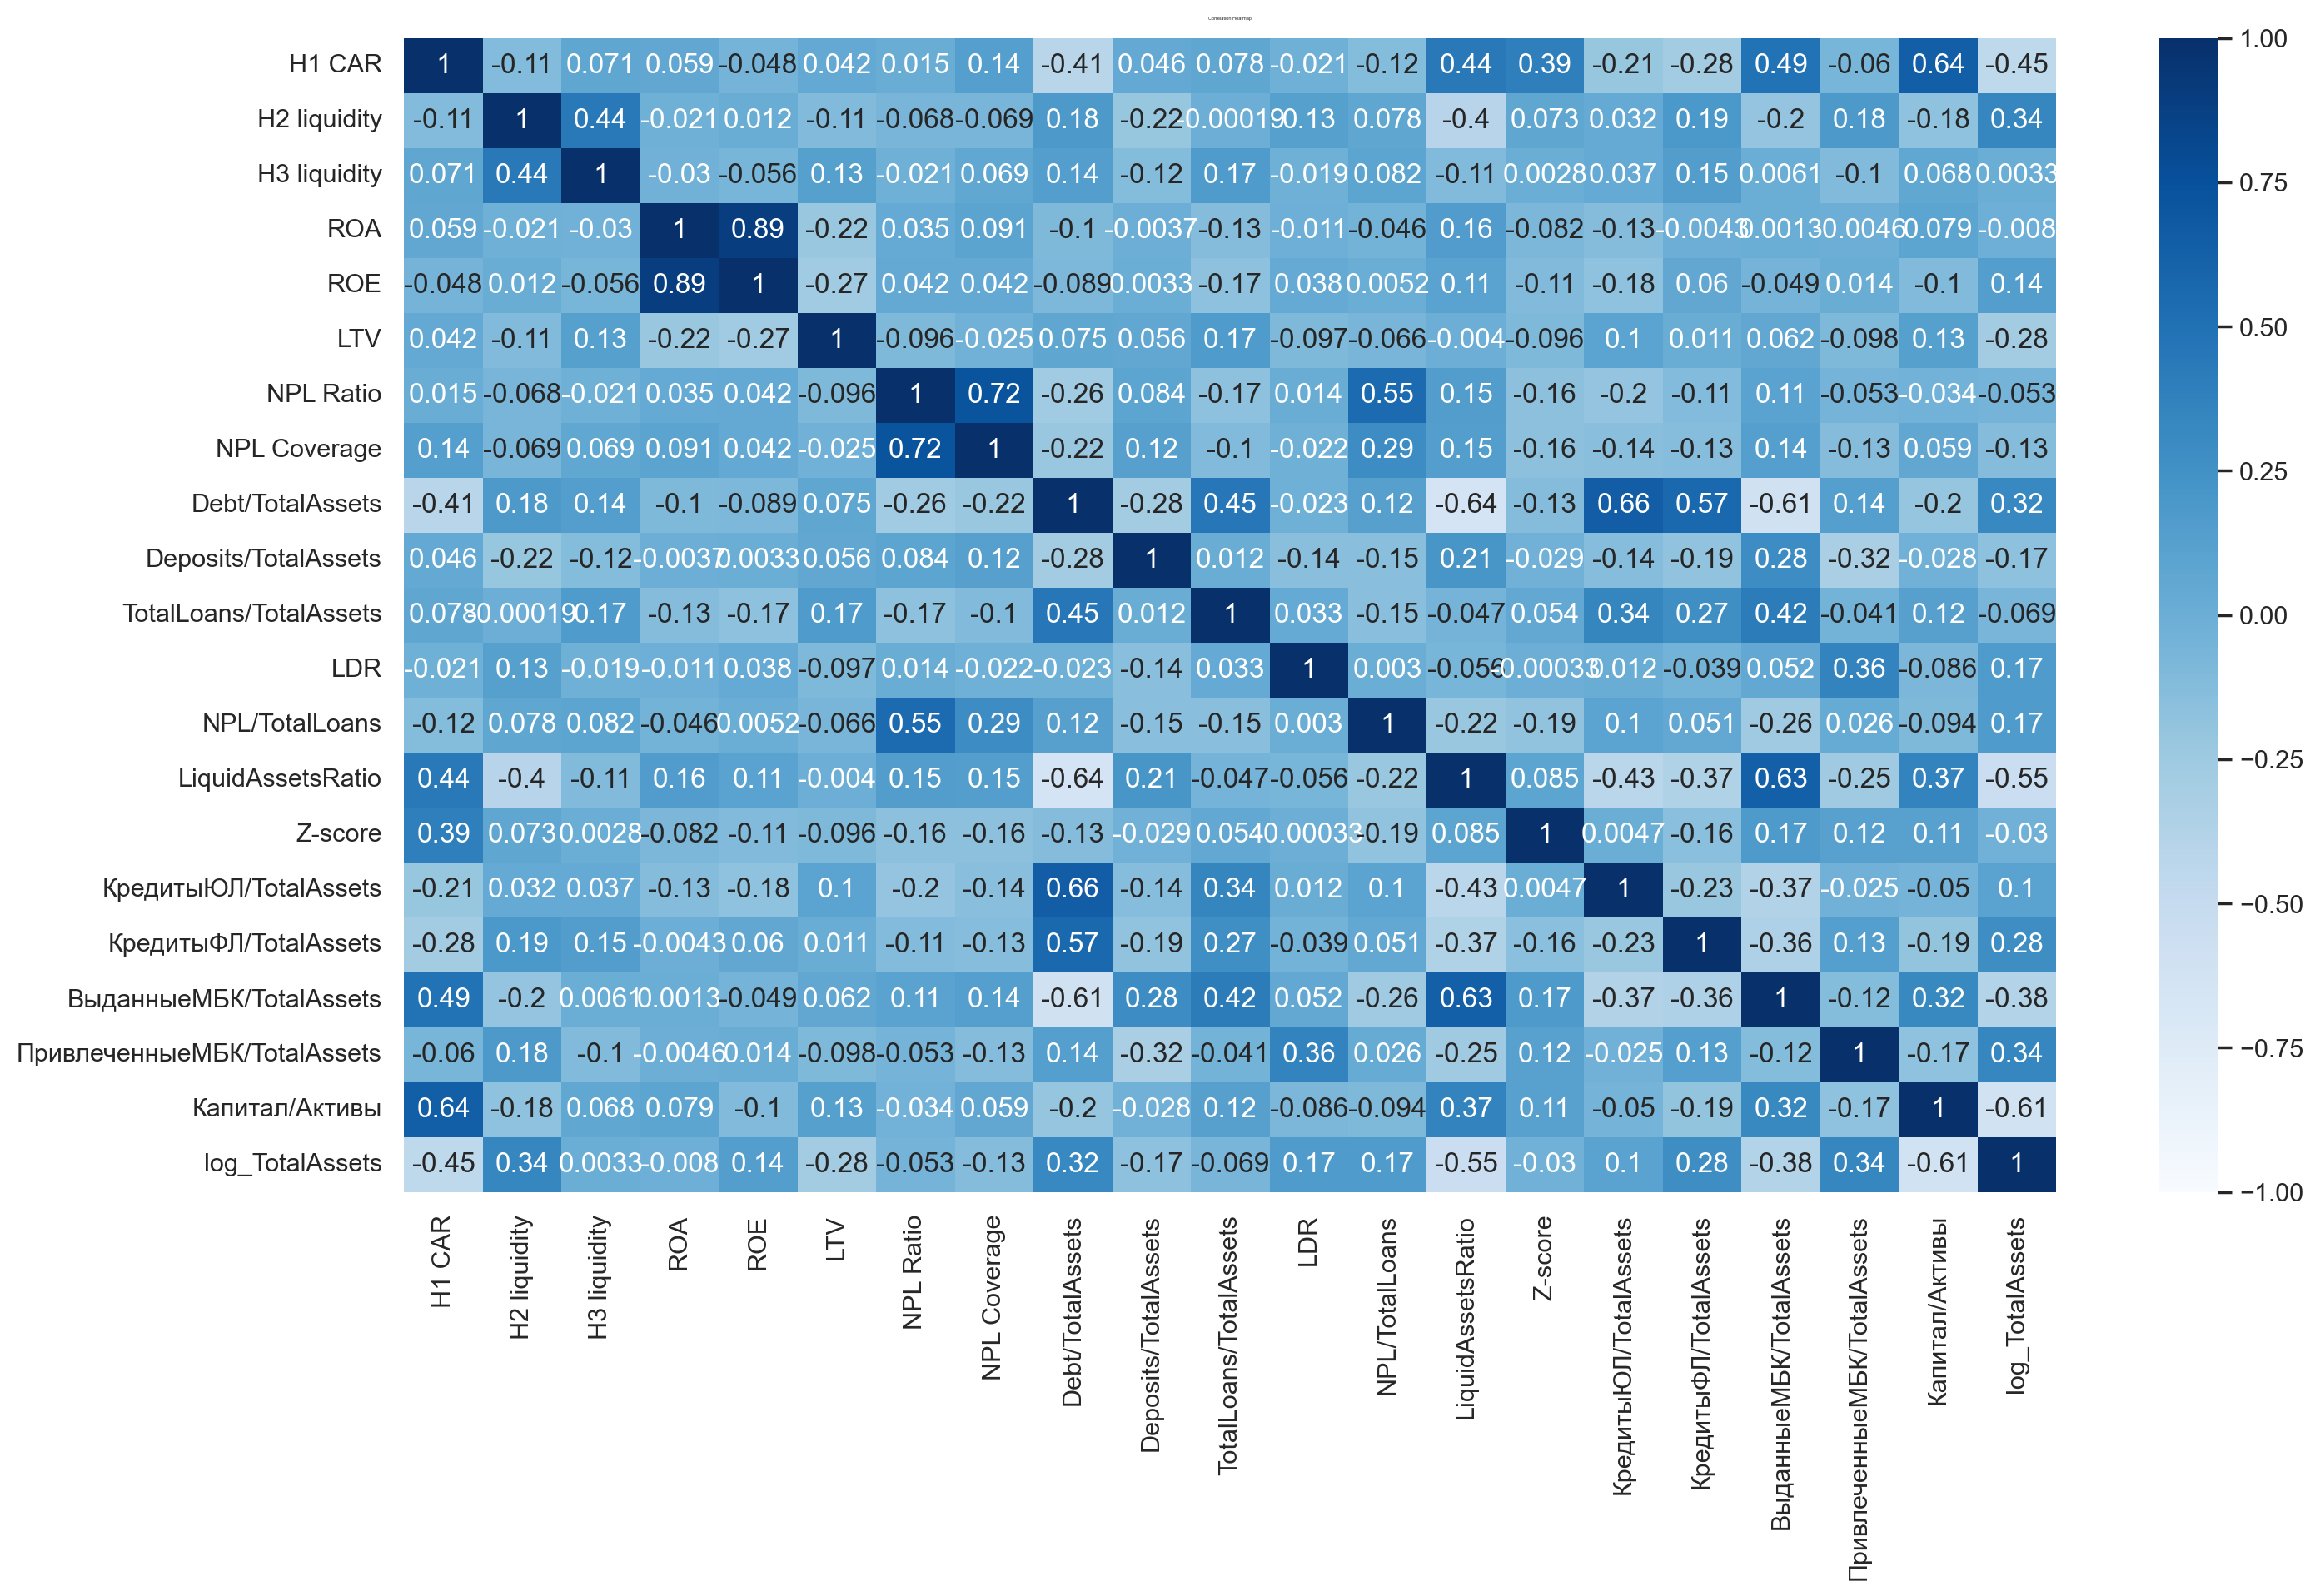

In [39]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':2}, pad=8);

## K-means

Заполняем пропуски при помощи KNN:

In [29]:
from clustering_functions import knn_nan_inputer

x_2023_knn = knn_nan_inputer(x_2023)
x_2021_knn = knn_nan_inputer(x_2021)
x_2020_knn = knn_nan_inputer(x_2020)
x_2019_knn = knn_nan_inputer(x_2019)

Метод Локтя

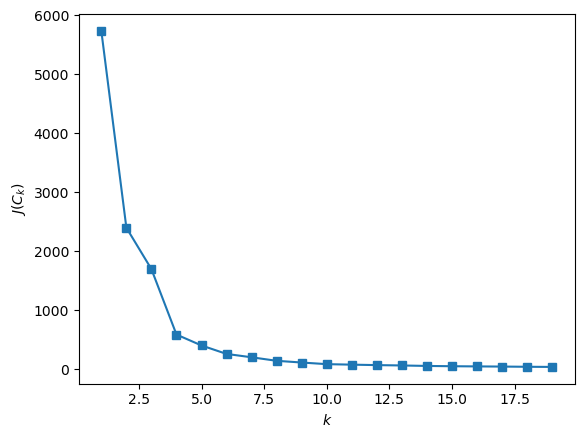

In [22]:
rg = range(1, 20)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=4).fit(x_2023_knn)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Выбираем 4 кластера

In [41]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = pd.DataFrame(x_2023_knn), 
                          num_clusters = [4], 
                          bank_name_column = df_2023['bank_name'], 
                          scaling = False,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                             clustering_before_dimreduce = False,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()

silhouette_score: 0.43926615


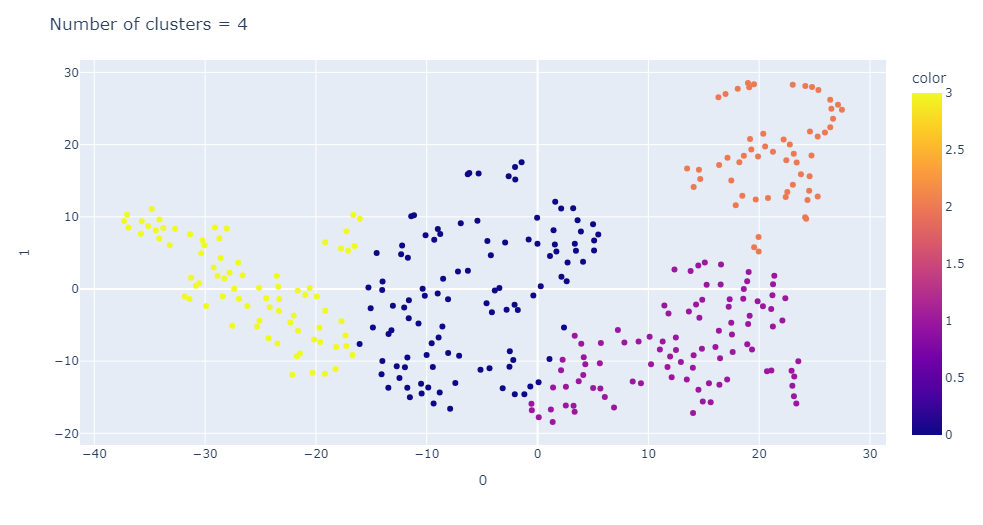

In [45]:
k_means.compute_cluster_stats(list_index = 0, cluster_index = 0)

Всего кластеров 4
Банков попало в кластер: 108


(array(['Райффайзен Банк', 'ЮниКредит Банк', 'БМ-Банк',
        'Банк Синара (СКБ-банк)', 'Инвестторгбанк', '«Кубань Кредит»',
        'Локо-Банк', 'БКС Банк', 'Ренессанс Банк', 'ИНГ Банк',
        'Челябинвестбанк', 'Модульбанк', 'ГЕНБАНК', 'Тимер Банк',
        'Кредит Урал Банк', 'МС Банк Рус', 'Мидзухо Банк',
        'Еврофинанс Моснарбанк', 'Алмазэргиэнбанк', '«Хлынов»',
        'Банк «Национальный стандарт»', '«Ишбанк»', 'НС Банк',
        'Энерготрансбанк', 'Урал ФД', 'Тольяттихимбанк', 'БыстроБанк',
        'Яндекс Банк', '«ТАТСОЦБАНК»', 'Банк Акцепт', 'Прио-Внешторгбанк',
        'Банк «АГРОПРОМКРЕДИТ»', 'АКИБАНК', 'Энергобанк', 'SEB',
        'Норвик Банк', '«Банк ФИНАМ»', '«КОШЕЛЕВ-БАНК»', 'НК Банк',
        'Банк «ОРЕНБУРГ»', '«Александровский»', '«Цифра банк»',
        '«РУСНАРБАНК»', 'Банк Казани', 'Банк «СЛАВИЯ»', 'Датабанк',
        'Углеметбанк', 'Джей энд Ти Банк', 'Солид Банк', 'БЖФ Банк',
        'Банк «ИТУРУП»', '«Развитие-Столица»', 'НИКО-Банк',
        'Банк «Пой

In [46]:
k_means.compute_cluster_stats(list_index = 0, cluster_index = 1)

Всего кластеров 4
Банков попало в кластер: 96


(array(['Газэнергобанк', 'Банк «Кузнецкий»',
        '«Енисейский объединенный банк»', 'Долинск', 'Владбизнесбанк',
        'Банк БКФ', 'СИНКО-БАНК', '«Первый Инвестиционный Банк»',
        '«Северный Народный Банк»', '«Белгородсоцбанк»', 'МОСКОМБАНК',
        'Роял Кредит Банк', 'Свой Банк', 'Банк «Вологжанин»',
        'Автоградбанк', 'МТИ Банк', 'Далена Банк', 'Банк Оранжевый',
        'Банк Кремлевский', 'Живаго банк',
        '«Муниципальный Камчатпрофитбанк»', 'Тендербанк',
        'Алтайкапиталбанк', 'Уралфинанс', 'Кетовский Коммерческий Банк',
        'Крокус-Банк', 'Яринтербанк', 'Уралпромбанк', 'АвтоКредитБанк',
        'Донкомбанк', 'Москва-Сити', 'Банк «Элита»', 'Банк Глобус',
        '«Сельмашбанк»', 'Примтеркомбанк', 'Костромаселькомбанк',
        'Банк Пермь', 'Банк РМП', 'Новый Московский Банк', '«Арзамас»',
        'Банк «Саратов»', 'Первый Дортрансбанк', 'Внешфинбанк',
        'Банк «Приобье»', 'ИТ Банк', 'ЭКСИ-Банк', 'Банк НООСФЕРА',
        'Алтынбанк', 'Республикан

In [47]:
k_means.compute_cluster_stats(list_index = 0, cluster_index = 2)

Всего кластеров 4
Банков попало в кластер: 57


(array(['Ситибанк', '«Траст»', 'СПБ Банк', 'Авто Финанс Банк', 'ВУЗ-банк',
        'Мир Бизнес Банк', 'Банк «ЦентроКредит»', 'Ozon Банк',
        'Москоммерцбанк', 'Российская Финансовая Корпорация',
        '«Банк Кредит Свисс (Москва)»', 'Банк «МБА-МОСКВА»',
        'Русьуниверсалбанк', '«САРОВБИЗНЕСБАНК»', 'Банк «Мир Привилегий»',
        'Зираат Банк', 'Бланк', 'НОКССБАНК', 'Промсельхозбанк',
        'Банк «СИСТЕМА»', 'Банк «Соколовcкий»', 'Вэйбанк', 'Земкомбанк',
        'Банк Стрела', 'Банк «Вятич»', 'МВС Банк',
        'Национальный расчетный депозитарий (НРД)',
        'Дж. П. Морган Банк Интернешнл', 'МСП Банк',
        '«Коммерческий Индо Банк»', 'Тойота Банк', 'Платежный Центр',
        'Азия-Инвест Банк', 'Эйч-Эс-Би-Си Банк (HSBC)', 'ИНКАХРАН',
        'Чайнасельхозбанк', 'ЮMoney', 'СПБ Клиринг', 'Голдман Сакс Банк',
        '«Расчетные Решения»', 'Юнистрим', 'Банк 131',
        'Первый Клиентский Банк', 'Деньги.Мэйл.Ру', 'РНКО «Единая касса»',
        'Вестерн Юнион ДП Вос

In [48]:
k_means.compute_cluster_stats(list_index = 0, cluster_index = 3)

Всего кластеров 4
Банков попало в кластер: 78


(array(['Сбербанк', 'ВТБ', 'Газпромбанк', 'Альфа-Банк',
        'Московский кредитный банк (МКБ)', 'Россельхозбанк',
        'Банк «Открытие»', 'Совкомбанк', 'Банк ДОМ.РФ', 'Росбанк',
        'Тинькофф Банк', 'Банк «РОССИЯ»', 'Банк «Санкт-Петербург»',
        'Ак Барс Банк', 'Новикомбанк', 'Уралсиб', 'Почта Банк',
        'АКБ «БЭНК ОФ ЧАЙНА»', 'МТС Банк', 'РНКБ',
        'Уральский банк реконструкции и развития (УБРиР)', 'ОТП Банк',
        'Банк ТКБ', 'Банк ЗЕНИТ', 'Хоум Банк', 'Абсолют Банк', 'Экспобанк',
        'ББР Банк', 'Русский Стандарт',
        'Азиатско-Тихоокеанский банк (АТБ)', 'Кредит Европа Банк',
        'Металлинвестбанк', 'Банк «Аверс»', 'Ингосстрах Банк',
        'Банк Интеза', 'Примсоцбанк', 'Авангард', 'Банк «Центр-инвест»',
        'Таврический Банк', 'Банк «Левобережный»', 'МЕТКОМБАНК',
        'Банк Финсервис', 'Сургутнефтегазбанк',
        'Национальный Резервный Банк', 'Банк «Солидарность»', 'СДМ-Банк',
        'Банк МФК', 'Фора-Банк', 'КИВИ Банк', 'Банк «При

## DBSCAN

In [52]:
dbscan = DBSCAN(eps=40, min_samples=3)
clustering = dbscan.fit(x_2023_knn)
labels = clustering.labels_
sample_cores=np.zeros_like(labels,dtype=bool)
sample_cores[clustering.core_sample_indices_]=True
n_clusters=len(set(labels))- (1 if -1 in labels else 0)
print('No of clusters:',n_clusters)

No of clusters: 1


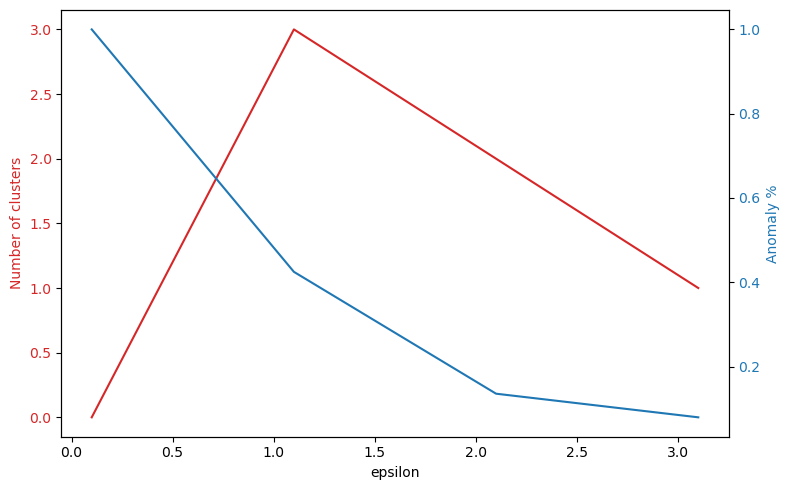

In [55]:
# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 0.1
eps_history = [eps]

while outlier_percentage > 0.1:    
    model = DBSCAN(eps=eps, min_samples=3).fit(x_2023_knn)
    
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 1
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)

iterations = eps_history[:-1]

fig, ax1 = plt.subplots(figsize=(8,5))
color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('Number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # инициализация второй оси в соотвествии с размером первой

color = 'tab:blue'
ax2.set_ylabel('Anomaly %', color=color)
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

In [56]:
dbscan = DBSCAN(eps=1.2, min_samples=3)
clustering = dbscan.fit(x_2023_knn)
labels = clustering.labels_
sample_cores=np.zeros_like(labels,dtype=bool)
sample_cores[clustering.core_sample_indices_]=True
n_clusters=len(set(labels))- (1 if -1 in labels else 0)
print('No of clusters:',n_clusters)

No of clusters: 4


In [57]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{-1: 122, 0: 4, 1: 207, 2: 3, 3: 3}

In [60]:
pca = PCA(n_components=3)
components = pca.fit_transform(x_2023_knn)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [61]:
pca = PCA(n_components=2)
components = pca.fit_transform(x_2023_knn)

fig = px.scatter(components, x=0, y=1, color=labels)
fig.show()

In [62]:
df_2023['labels'] = labels

In [63]:
df_2023['labels'].value_counts().keys()

Index([1, -1, 0, 2, 3], dtype='int64', name='labels')

In [64]:
i=0
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)].describe()

['Альфа-Банк' 'Московский кредитный банк (МКБ)' 'Совкомбанк' 'Росбанк']


Вложения в ценные бумаги  Кредитный портфель  \
count              4.000000e+00        4.000000e+00   
mean               6.363660e+08        3.022326e+09   
std                4.197035e+08        1.941133e+09   
min                1.237043e+08        1.391128e+09   
25%                3.942241e+08        1.736521e+09   
50%                6.744936e+08        2.490594e+09   
75%                9.166355e+08        3.776399e+09   
max                1.072772e+09        5.716990e+09   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                     4.000000e+00  4.000000e+00   
mean                                      1.815849e+07  4.640815e+09   
std                                       1.123349e+07  2.773822e+09   
min                                       2.802305e+06  2.173518e+09   
25%                                       1.399565e+07  2.798859e+09   
50%                                       2.039185e+07  3.989170e+09   
75%                                       2.455469e+07  5.831125e+09   
max                                       2.904796e+07  8.411400e+09   

            Векселя  Вклады физических лиц  Вложения в акции  \
count  4.000000e+00           4.000000e+00      4.000000e+00   
mean   5.932675e+06           7.049775e+08      2.179024e+07   
std    1.135410e+07           4.743633e+08      1.595739e+07   
min    0.000000e+00           2.898662e+08      1.111130e+05   
25%    0.000000e+00           4.581513e+08      1.559392e+07   
50%    3.878510e+05           5.730422e+08      2.486301e+07   
75%    6.320526e+06           8.198683e+08      3.105933e+07   
max    2.295500e+07           1.383959e+09      3.732385e+07   

       Вложения в векселя  Вложения в капиталы других организаций  \
count                 4.0                            4.000000e+00   
mean                250.0                            2.868620e+07   
std                 500.0                            2.153621e+07   
min                   0.0                            8.056345e+06   
25%                   0.0                            1.357598e+07   
50%                   0.0                            2.534051e+07   
75%                 250.0                            4.045072e+07   
max                1000.0                            5.600743e+07   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count          4.000000e+00  4.000000e+00                    4.000000e+00   
mean           6.145755e+08  4.142979e+08                    7.018714e+07   
std            4.106557e+08  1.048273e+08                    1.011616e+08   
min            1.235932e+08  2.979304e+08                    1.063178e+07   
25%            3.662035e+08  3.396464e+08                    1.618422e+07   
50%            6.454543e+08  4.256996e+08                    2.434745e+07   
75%            8.938263e+08  5.003511e+08                    7.835037e+07   
max            1.043800e+09  5.078621e+08                    2.214219e+08   

       Высоколиквидные активы       Капитал  \
count            4.000000e+00  4.000000e+00   
mean             2.828469e+08  4.439646e+08   
std              1.751906e+08  2.686555e+08   
min              1.441070e+08  2.386534e+08   
25%              1.821491e+08  2.991674e+08   
50%              2.253758e+08  3.498918e+08   
75%              3.260736e+08  4.946890e+08   
max              5.365288e+08  8.374214e+08   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         4.000000e+00              4.000000e+00   
mean                          2.027128e+09              9.296844e+08   
std                           1.406087e+09              7.425792e+08   
min                           6.485802e+08              2.115384e+08   
25%                           9.390006e+08              6.096927e+08   
50%                           1.950730e+09              7.679594e+08   
75%                           3.038857e+0

In [65]:
i=1
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)].describe()

['Ак Барс Банк' 'Новикомбанк' 'Уралсиб' 'МТС Банк'
 'Уральский банк реконструкции и развития (УБРиР)' 'ОТП Банк' 'Банк ТКБ'
 'Банк ЗЕНИТ' 'Абсолют Банк' 'Экспобанк' 'Русский Стандарт'
 'Азиатско-Тихоокеанский банк (АТБ)' 'Кредит Европа Банк'
 'Металлинвестбанк' 'Банк «Аверс»' 'Ингосстрах Банк' 'Авангард'
 'Банк «Левобережный»' 'МЕТКОМБАНК' 'Банк Финсервис' 'Сургутнефтегазбанк'
 'Национальный Резервный Банк' 'Банк «Солидарность»' 'СДМ-Банк' 'Банк МФК'
 'Фора-Банк' 'КИВИ Банк' 'Банк «Приморье»' 'Банк «Объединенный капитал»'
 'Челиндбанк' 'СЕВЕРГАЗБАНК' 'ГЕНБАНК' 'Чайна Констракшн'
 'Дальневосточный Банк' 'АРЕСБАНК' 'Банк «Держава»' 'Интерпрогрессбанк'
 'Банк «ПСКБ»' 'МОРСКОЙ БАНК' 'ДенизБанк Москва' 'Ланта-Банк'
 'Кредит Урал Банк' 'РосДорБанк' 'Алмазэргиэнбанк' '«Хлынов»'
 'Банк «Национальный стандарт»' 'НБД-Банк' 'банк Раунд' 'SBI Банк'
 '«Ишбанк»' '«Ури Банк»' 'Реалист Банк' 'НС Банк' 'Энерготрансбанк'
 'Банк «РЕСО Кредит»' 'Инбанк' 'Тольяттихимбанк' 'БыстроБанк' 'Экономбанк'
 'Яндекс

Вложения в ценные бумаги  Кредитный портфель  \
count              1.420000e+02        2.060000e+02   
mean               1.092497e+07        2.130276e+07   
std                2.378772e+07        6.307853e+07   
min                4.072000e+03        8.306000e+03   
25%                3.956525e+05        8.183268e+05   
50%                2.098038e+06        2.660070e+06   
75%                7.680928e+06        8.118271e+06   
max                1.678549e+08        5.016412e+08   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                     1.720000e+02  2.070000e+02   
mean                                      2.830812e+05  4.665226e+07   
std                                       1.012187e+06  1.153303e+08   
min                                       1.000000e+00  6.058090e+05   
25%                                       7.492500e+02  2.690730e+06   
50%                                       6.829500e+03  8.062772e+06   
75%                                       7.567525e+04  3.256067e+07   
max                                       7.150281e+06  8.793088e+08   

            Векселя  Вклады физических лиц  Вложения в акции  \
count  2.070000e+02           2.070000e+02      2.070000e+02   
mean   3.170976e+05           1.039901e+07      2.979224e+05   
std    1.836429e+06           2.439911e+07      2.262560e+06   
min    0.000000e+00           0.000000e+00      0.000000e+00   
25%    0.000000e+00           3.416510e+05      0.000000e+00   
50%    0.000000e+00           1.812776e+06      0.000000e+00   
75%    6.304000e+03           7.558694e+06      1.079250e+04   
max    1.890764e+07           1.557381e+08      3.137227e+07   

       Вложения в векселя  Вложения в капиталы других организаций  \
count          207.000000                            2.070000e+02   
mean          6891.207729                            4.090749e+05   
std          46000.200406                            2.397052e+06   
min              0.000000                            0.000000e+00   
25%              0.000000                            0.000000e+00   
50%              0.000000                            0.000000e+00   
75%              0.000000                            2.550000e+01   
max         493166.000000                            3.109407e+07   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count          2.070000e+02  2.070000e+02                    2.070000e+02   
mean           7.189607e+06  9.727647e+06                    6.659233e+05   
std            1.917757e+07  2.570543e+07                    5.091238e+06   
min            0.000000e+00  0.000000e+00                    0.000000e+00   
25%            0.000000e+00  6.776650e+05                    0.000000e+00   
50%            4.507770e+05  1.707900e+06                    0.000000e+00   
75%            5.150652e+06  6.786640e+06                    9.304000e+03   
max            1.678505e+08  1.989457e+08                    6.890764e+07   

       Высоколиквидные активы       Капитал  \
count            2.070000e+02  2.070000e+02   
mean             4.337889e+06  6.598763e+06   
std              9.549078e+06  1.429197e+07   
min              1.314000e+04 -2.347537e+06   
25%              2.210565e+05  6.669840e+05   
50%              7.049220e+05  1.614280e+06   
75%              3.462794e+06  5.733326e+06   
max              7.607623e+07  1.013506e+08   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         2.070000e+02              2.070000e+02   
mean                          1.057686e+07              9.999319e+06   
std                           3.831208e+07              3.758752e+07   
min                           0.000000e+00              0.000000e+00   
25%                           5.001540e+05              7.754200e+04   
50%                           1.702949e+06              3.236720e+05   
75%                           6.284631e+0

In [66]:
i=2
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)].describe()

['ББР Банк' 'Примсоцбанк' 'Банк «Центр-инвест»']


Вложения в ценные бумаги  Кредитный портфель  \
count              3.000000e+00        3.000000e+00   
mean               6.665796e+06        9.750625e+07   
std                5.773106e+06        7.668631e+06   
min                1.700000e+01        9.191092e+07   
25%                4.966606e+06        9.313558e+07   
50%                9.933194e+06        9.436025e+07   
75%                9.998686e+06        1.003039e+08   
max                1.006418e+07        1.062476e+08   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                         3.000000  3.000000e+00   
mean                                     202572.333333  1.641468e+08   
std                                      122075.826404  5.048921e+07   
min                                       63522.000000  1.292713e+08   
25%                                      157794.000000  1.351984e+08   
50%                                      252066.000000  1.411255e+08   
75%                                      272097.500000  1.815845e+08   
max                                      292129.000000  2.220436e+08   

            Векселя  Вклады физических лиц  Вложения в акции  \
count  3.000000e+00           3.000000e+00          3.000000   
mean   2.023347e+06           6.617567e+07          5.666667   
std    2.902290e+06           2.016020e+07          9.814955   
min    1.771800e+04           5.395105e+07          0.000000   
25%    3.593590e+05           5.454116e+07          0.000000   
50%    7.010000e+05           5.513127e+07          0.000000   
75%    3.026162e+06           7.228798e+07          8.500000   
max    5.351324e+06           8.944469e+07         17.000000   

       Вложения в векселя  Вложения в капиталы других организаций  \
count                 3.0                            3.000000e+00   
mean                  0.0                            4.756807e+05   
std                   0.0                            8.008747e+05   
min                   0.0                            7.690000e+02   
25%                   0.0                            1.335250e+04   
50%                   0.0                            2.593600e+04   
75%                   0.0                            7.131365e+05   
max                   0.0                            1.400337e+06   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count          3.000000e+00  3.000000e+00                    3.000000e+00   
mean           6.665791e+06  3.929400e+07                    2.029574e+06   
std            5.773116e+06  4.686320e+07                    2.913000e+06   
min            0.000000e+00  3.853400e+06                    1.771800e+04   
25%            4.966597e+06  1.272698e+07                    3.593590e+05   
50%            9.933194e+06  2.160057e+07                    7.010000e+05   
75%            9.998686e+06  5.701430e+07                    3.035502e+06   
max            1.006418e+07  9.242803e+07                    5.370003e+06   

       Высоколиквидные активы       Капитал  \
count            3.000000e+00  3.000000e+00   
mean             1.359019e+07  1.767979e+07   
std              4.495861e+06  1.472425e+06   
min              1.057386e+07  1.598299e+07   
25%              1.100656e+07  1.720896e+07   
50%              1.143926e+07  1.843492e+07   
75%              1.509836e+07  1.852818e+07   
max              1.875747e+07  1.862145e+07   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         3.000000e+00              3.000000e+00   
mean                          6.078798e+07              3.671827e+07   
std                           2.569541e+07              3.279329e+07   
min                           3.632849e+07              4.348293e+06   
25%                           4.740066e+07              2.011786e+07   
50%                           5.847282e+07              3.588742e+07   
75%                           7.301772e+0

In [67]:
i=3
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)].describe()

['Дойче Банк' 'Эм-Ю-Эф-Джи Банк (Евразия)' 'Коммерцбанк (Евразия)']


Вложения в ценные бумаги  Кредитный портфель  \
count                       1.0        3.000000e+00   
mean                  4666180.0        2.398958e+06   
std                         NaN        2.481678e+06   
min                   4666180.0        2.144900e+04   
25%                   4666180.0        1.111884e+06   
50%                   4666180.0        2.202320e+06   
75%                   4666180.0        3.587713e+06   
max                   4666180.0        4.973106e+06   

       Просроченная задолженность в кредитном портфеле  Total Assets  Векселя  \
count                                         2.000000  3.000000e+00      3.0   
mean                                        561.000000  6.888651e+07      0.0   
std                                         787.716954  3.973135e+06      0.0   
min                                           4.000000  6.550947e+07      0.0   
25%                                         282.500000  6.669759e+07      0.0   
50%                                         561.000000  6.788570e+07      0.0   
75%                                         839.500000  7.057503e+07      0.0   
max                                        1118.000000  7.326436e+07      0.0   

       Вклады физических лиц  Вложения в акции  Вложения в векселя  \
count                    3.0               3.0                 3.0   
mean                     0.0               0.0                 0.0   
std                      0.0               0.0                 0.0   
min                      0.0               0.0                 0.0   
25%                      0.0               0.0                 0.0   
50%                      0.0               0.0                 0.0   
75%                      0.0               0.0                 0.0   
max                      0.0               0.0                 0.0   

       Вложения в капиталы других организаций  Вложения в облигации  \
count                                     3.0          3.000000e+00   
mean                                      0.0          1.555393e+06   
std                                       0.0          2.694020e+06   
min                                       0.0          0.000000e+00   
25%                                       0.0          0.000000e+00   
50%                                       0.0          0.000000e+00   
75%                                       0.0          2.333090e+06   
max                                       0.0          4.666180e+06   

       Выданные МБК  Выпущенные облигации и векселя  Высоколиквидные активы  \
count  3.000000e+00                             3.0            3.000000e+00   
mean   5.363354e+07                             0.0            9.870308e+06   
std    8.697978e+06                             0.0            6.656504e+06   
min    4.549548e+07                             0.0            3.554612e+06   
25%    4.905031e+07                             0.0            6.394477e+06   
50%    5.260515e+07                             0.0            9.234342e+06   
75%    5.770258e+07                             0.0            1.302816e+07   
max    6.280000e+07                             0.0            1.682197e+07   

            Капитал  Кредиты предприятиям и организациям  \
count  3.000000e+00                         3.000000e+00   
mean   2.630991e+07                         2.398958e+06   
std    3.147346e+06                         2.481678e+06   
min    2.349900e+07                         2.144900e+04   
25%    2.460970e+07                         1.111884e+06   
50%    2.572040e+07                         2.202320e+06   
75%    2.771536e+07                         3.587713e+06   
max    2.971033e+07                         4.973106e+06   

       Кредиты физическим лицам    ЛОРО-счета  НОСТРО-счета  Облигации  \
count                       3.0  3.000000e+00  3.000000e+00        3.0   
mean                        0.0  1.226072e+06  9.644917e+06        0.0   
std                         0.0  2.

In [68]:
i=-1
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels'] == i]['bank_name'].values)].describe()

['Сбербанк' 'ВТБ' 'Газпромбанк' 'Россельхозбанк' 'Банк «Открытие»'
 'Банк ДОМ.РФ' 'Райффайзен Банк' 'Тинькофф Банк' 'Банк «РОССИЯ»'
 'ЮниКредит Банк' 'Банк «Санкт-Петербург»' 'Почта Банк' 'Ситибанк'
 'БМ-Банк' 'АКБ «БЭНК ОФ ЧАЙНА»' 'РНКБ' 'Хоум Банк' '«Траст»'
 'Банк Синара (СКБ-банк)' 'Инвестторгбанк' '«Кубань Кредит»' 'Локо-Банк'
 'Газэнергобанк' 'Банк Интеза' 'БКС Банк' 'Ренессанс Банк'
 'Таврический Банк' 'СПБ Банк' 'ИНГ Банк' 'Авто Финанс Банк'
 'Челябинвестбанк' 'ВУЗ-банк' 'Модульбанк' 'Мир Бизнес Банк'
 'Банк «ЦентроКредит»' 'Ozon Банк' 'Москоммерцбанк' 'Тимер Банк'
 'Российская Финансовая Корпорация' 'МС Банк Рус' 'Мидзухо Банк'
 'Еврофинанс Моснарбанк' '«Банк Кредит Свисс (Москва)»' 'Урал ФД'
 '«ТАТСОЦБАНК»' 'Банк «МБА-МОСКВА»' 'SEB' 'Норвик Банк' 'Банк «Пойдём!»'
 'Русьуниверсалбанк' '«САРОВБИЗНЕСБАНК»' 'Банк «Мир Привилегий»'
 'Зираат Банк' 'Бланк' 'Банк «Снежинский»' 'Хакасский муниципальный банк'
 'Томскпромстройбанк' 'Контур.Банк' '«ГОРБАНК»' 'СОЦИУМ-БАНК' 'НОКССБАНК'
 '«

Вложения в ценные бумаги  Кредитный портфель  \
count              7.000000e+01        9.700000e+01   
mean               2.172647e+08        7.859002e+08   
std                9.411249e+08        4.148790e+09   
min                3.500000e+01        2.110000e+02   
25%                7.138965e+05        3.639250e+05   
50%                9.556718e+06        5.541076e+06   
75%                4.159250e+07        4.162698e+07   
max                6.292502e+09        3.656594e+10   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                     7.000000e+01  1.220000e+02   
mean                                      7.637962e+06  1.042760e+09   
std                                       2.558275e+07  5.354814e+09   
min                                       1.000000e+00  1.087760e+05   
25%                                       4.463750e+03  2.486670e+06   
50%                                       1.820570e+05  2.662436e+07   
75%                                       1.766642e+06  1.362856e+08   
max                                       1.552683e+08  5.069572e+10   

            Векселя  Вклады физических лиц  Вложения в акции  \
count  1.220000e+02           1.220000e+02      1.220000e+02   
mean   2.212795e+06           1.792162e+08      2.555311e+06   
std    1.268463e+07           1.126750e+09      1.245146e+07   
min    0.000000e+00           0.000000e+00      0.000000e+00   
25%    0.000000e+00           0.000000e+00      0.000000e+00   
50%    0.000000e+00           1.806250e+04      0.000000e+00   
75%    0.000000e+00           4.127222e+06      3.075000e+01   
max    1.067790e+08           1.145818e+10      9.104845e+07   

       Вложения в векселя  Вложения в капиталы других организаций  \
count        1.220000e+02                            1.220000e+02   
mean         1.783503e+05                            2.739958e+07   
std          1.165818e+06                            1.576994e+08   
min          0.000000e+00                            0.000000e+00   
25%          0.000000e+00                            0.000000e+00   
50%          0.000000e+00                            0.000000e+00   
75%          0.000000e+00                            7.995500e+03   
max          1.120498e+07                            1.270984e+09   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count          1.220000e+02  1.220000e+02                    1.220000e+02   
mean           1.219264e+08  1.030137e+08                    1.255271e+07   
std            7.105310e+08  4.868036e+08                    7.411172e+07   
min            0.000000e+00  0.000000e+00                    0.000000e+00   
25%            0.000000e+00  9.814998e+05                    0.000000e+00   
50%            2.268450e+04  7.124541e+06                    0.000000e+00   
75%            1.207200e+07  3.613918e+07                    0.000000e+00   
max            6.246095e+09  5.141593e+09                    7.219752e+08   

       Высоколиквидные активы       Капитал  \
count            1.220000e+02  1.220000e+02   
mean             9.717209e+07  9.474390e+07   
std              3.687913e+08  5.928772e+08   
min              1.860000e+02 -1.383053e+09   
25%              2.415205e+05  5.032212e+05   
50%              2.036298e+06  4.383454e+06   
75%              1.251459e+07  2.057255e+07   
max              2.837424e+09  6.009351e+09   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         1.220000e+02              1.220000e+02   
mean                          4.186848e+08              2.047247e+08   
std                           2.342530e+09              1.420799e+09   
min                           0.000000e+00              0.000000e+00   
25%                           1.307750e+03              0.000000e+00   
50%                           6.496605e+05              2.200850e+04   
75%                           7.993747e+0

## SOM

In [41]:
!pip install minisom

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10663 sha256=9ee48c9e065f3ec7b02c89455779df1fcb0fabc05dbaefd7666e66ad8ace4854
  Stored in directory: c:\users\masha\appdata\local\pip\cache\wheels\61\e8\de\cd2df73e85e467e1cf90ff918c6d6f388eff8e9029dae8bd78
Successfully built minisom


In [1]:
from minisom import MiniSom  

In [24]:
x_2023_knn.shape

(339, 21)

In [45]:
from minisom import MiniSom

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

In [66]:
n_neurons = 5
m_neurons = 5
som = MiniSom(n_neurons, m_neurons, x_2023_knn.shape[1], sigma=1, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0, topology='hexagonal')

# som.pca_weights_init(X1)
som.train(x_2023_knn, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 9.864790685781195


In [67]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

<Axes: ylabel='distance from neurons in the neighbourhood'>

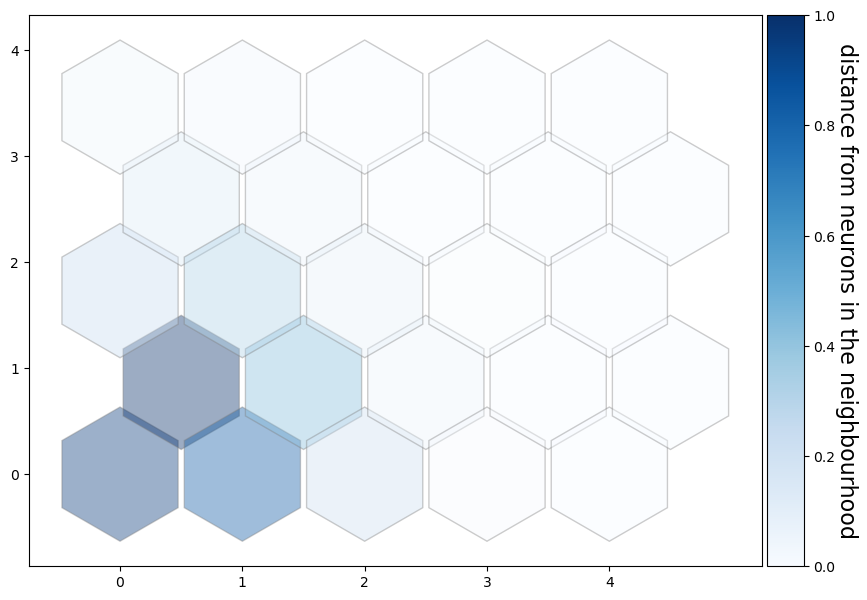

In [70]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

# markers = ['o', '+', 'x']
# colors = ['C0', 'C1', 'C2']
for cnt, x in enumerate(x_2023_knn):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2
    plt.plot(wx, wy)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

In [ ]:
# https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb

In [69]:
from sklearn_som.som import SOM

In [70]:
som = SOM(m=3, n=3, dim=x_2023_knn.shape[1], lr=1, sigma=1, max_iter=3000, random_state=552)
som.fit(x_2023_knn)
labels = som.predict(x_2023_knn)

In [71]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 32, 1: 134, 2: 134, 3: 2, 4: 7, 5: 17, 6: 6, 7: 3, 8: 4}

In [72]:
pca = PCA(n_components=2)
components = pca.fit_transform(x_2023_knn)

fig = px.scatter(components, x=0, y=1, color=labels)
fig.show()

In [74]:
df_2023['labels_som'] = labels

In [79]:
i=0
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['Газэнергобанк' 'Русьуниверсалбанк' 'НОКССБАНК' 'Банк «СИСТЕМА»'
 'Банк «Соколовcкий»' 'Банк «Ермак»' 'Россита-Банк'
 'Русский Банк Сбережений' 'Вэйбанк' 'Народный инвестиционный банк (НИБ)'
 'Земкомбанк' 'Банк РСИ' 'ЕАТП Банк' 'Славянбанк' 'Балаково-Банк'
 'Классик Эконом Банк' 'Банк «Вятич»' 'БАНК КОСМОС' 'Банк «Гефест»'
 'Таганрогбанк' 'МВС Банк' 'Голдман Сакс Банк' 'Банк 131'
 'Первый Клиентский Банк' 'Деньги.Мэйл.Ру' 'РНКО «Единая касса»'
 'Вестерн Юнион ДП Восток' 'Северстройбанк' '«БАНК БЕРЕЙТ»' '«ЭЛЕКСИР»'
 'Промсвязьинвест' '«Дальний Восток»']


Вложения в ценные бумаги  Кредитный портфель  \
count              5.000000e+00        2.600000e+01   
mean               8.880464e+06        2.267314e+06   
std                1.888770e+07        8.105162e+06   
min                1.431100e+04        3.221000e+03   
25%                4.029300e+04        1.529315e+05   
50%                5.824700e+04        3.569095e+05   
75%                1.644616e+06        5.682422e+05   
max                4.264485e+07        4.162698e+07   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                        12.000000  3.200000e+01   
mean                                      65200.833333  6.551856e+06   
std                                      187542.347553  2.538015e+07   
min                                           1.000000  1.559690e+05   
25%                                          16.750000  7.093518e+05   
50%                                         327.000000  1.357240e+06   
75%                                        3740.750000  2.334328e+06   
max                                      650924.000000  1.449255e+08   

            Векселя  Вклады физических лиц  Вложения в акции  \
count     32.000000           3.200000e+01         32.000000   
mean    3185.343750           6.444832e+05       1146.656250   
std    15837.902935           3.014430e+06       4006.878864   
min        0.000000           0.000000e+00          0.000000   
25%        0.000000           0.000000e+00          0.000000   
50%        0.000000           1.013750e+04          0.000000   
75%        0.000000           1.174280e+05          0.000000   
max    89082.000000           1.708390e+07      17691.000000   

       Вложения в векселя  Вложения в капиталы других организаций  \
count           32.000000                                    32.0   
mean           873.812500                                     0.0   
std           4943.029954                                     0.0   
min              0.000000                                     0.0   
25%              0.000000                                     0.0   
50%              0.000000                                     0.0   
75%              0.000000                                     0.0   
max          27962.000000                                     0.0   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count          3.200000e+01  3.200000e+01                       32.000000   
mean           1.385552e+06  2.309561e+06                     3185.343750   
std            7.531141e+06  7.788133e+06                    15837.902935   
min            0.000000e+00  0.000000e+00                        0.000000   
25%            0.000000e+00  2.333258e+05                        0.000000   
50%            0.000000e+00  6.397000e+05                        0.000000   
75%            0.000000e+00  1.226159e+06                        0.000000   
max            4.262716e+07  4.450334e+07                    89082.000000   

       Высоколиквидные активы       Капитал  \
count            3.200000e+01  3.200000e+01   
mean             5.158865e+05  9.932519e+05   
std              1.311853e+06  1.543568e+06   
min              4.237000e+03  1.874600e+04   
25%              3.566150e+04  3.573105e+05   
50%              1.095945e+05  4.357905e+05   
75%              2.523395e+05  8.730612e+05   
max              6.990960e+06  8.233247e+06   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         3.200000e+01              3.200000e+01   
mean                          1.118860e+06              7.233328e+05   
std                           4.187942e+06              3.184622e+06   
min                           0.000000e+00              0.000000e+00   
25%                           1.293500e+03              0.000000e+00   
50%                           1.108425e+05              2.321350e+04   
75%                           3.980308e+0

In [80]:
i=1
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['Энергобанк' 'Банк «МБА-МОСКВА»' '«Банк ФИНАМ»' 'НК Банк'
 '«Александровский»' '«Цифра банк»' '«РУСНАРБАНК»' 'Банк «СЛАВИЯ»'
 'Датабанк' 'Углеметбанк' 'Солид Банк' 'БЖФ Банк' 'Банк «ИТУРУП»'
 '«Развитие-Столица»' 'НИКО-Банк' 'ЦМРБанк' 'Автоторгбанк' 'Алеф-Банк'
 'ЮГ-Инвестбанк' '«Форштадт»' 'РостФинанс' 'Банк «Венец»'
 '«Гарант-Инвест»' 'Зираат Банк' 'Трансстройбанк' 'ГУТА-БАНК'
 'Кузнецкбизнесбанк' 'Хакасский муниципальный банк' 'Агророс Банк'
 'Новобанк' 'Сибсоцбанк' 'Нацинвестпромбанк' 'ФИНСТАР БАНК'
 'Банк «Новый век»' 'Банк «Кузнецкий»' 'ПЕРВОУРАЛЬСКБАНК' '«Земский банк»'
 'Черноморский банк развития и реконструкции' 'КАМКОМБАНК'
 '«Енисейский объединенный банк»' 'Долинск' 'Владбизнесбанк'
 'Газтрансбанк' 'Банк БКФ' 'СИНКО-БАНК' '«Первый Инвестиционный Банк»'
 'СТРОЙЛЕСБАНК' '«Северный Народный Банк»' '«Белгородсоцбанк»'
 'МОСКОМБАНК' 'Роял Кредит Банк' 'Свой Банк' 'Банк «Вологжанин»'
 'Автоградбанк' 'МТИ Банк' '«Универсальный фондовый банк»' 'Далена Банк'
 'Банк Оранжевый' 'Брат

Вложения в ценные бумаги  Кредитный портфель  \
count              7.400000e+01        1.290000e+02   
mean               1.133716e+06        2.293649e+06   
std                1.442373e+06        2.517041e+06   
min                4.072000e+03        9.180000e+03   
25%                1.522940e+05        5.829260e+05   
50%                5.322925e+05        1.375072e+06   
75%                1.588297e+06        3.065954e+06   
max                7.128777e+06        1.582463e+07   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                     1.030000e+02  1.340000e+02   
mean                                      3.506768e+04  5.902125e+06   
std                                       1.219894e+05  5.203835e+06   
min                                       1.000000e+00  2.023060e+05   
25%                                       8.200000e+01  2.030984e+06   
50%                                       2.546000e+03  4.216340e+06   
75%                                       1.356750e+04  7.880210e+06   
max                                       1.017938e+06  2.138312e+07   

            Векселя  Вклады физических лиц  Вложения в акции  \
count  1.340000e+02           1.340000e+02        134.000000   
mean   4.218175e+04           1.632863e+06      19361.432836   
std    1.926484e+05           1.883385e+06      79734.964765   
min    0.000000e+00           0.000000e+00          0.000000   
25%    0.000000e+00           3.018862e+05          0.000000   
50%    0.000000e+00           8.747545e+05          0.000000   
75%    0.000000e+00           2.412335e+06          0.000000   
max    1.716900e+06           8.584479e+06     532678.000000   

       Вложения в векселя  Вложения в капиталы других организаций  \
count          134.000000                              134.000000   
mean          5333.582090                             4550.895522   
std          43944.325967                            27311.517527   
min              0.000000                                0.000000   
25%              0.000000                                0.000000   
50%              0.000000                                0.000000   
75%              0.000000                                0.000000   
max         493166.000000                           255933.000000   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count          1.340000e+02  1.340000e+02                    1.340000e+02   
mean           6.013868e+05  1.826505e+06                    4.218175e+04   
std            1.201470e+06  2.196339e+06                    1.926484e+05   
min            0.000000e+00  0.000000e+00                    0.000000e+00   
25%            0.000000e+00  5.568178e+05                    0.000000e+00   
50%            2.561600e+04  1.061208e+06                    0.000000e+00   
75%            5.982602e+05  1.996250e+06                    0.000000e+00   
max            7.103848e+06  1.188358e+07                    1.716900e+06   

       Высоколиквидные активы       Капитал  \
count            1.340000e+02  1.340000e+02   
mean             7.323253e+05  1.348842e+06   
std              1.137942e+06  1.336454e+06   
min              1.314000e+04  1.155900e+04   
25%              1.208750e+05  5.070580e+05   
50%              3.264230e+05  8.694170e+05   
75%              7.549865e+05  1.647191e+06   
max              6.735276e+06  8.250858e+06   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         1.340000e+02              1.340000e+02   
mean                          1.597891e+06              5.781703e+05   
std                           1.929021e+06              1.102092e+06   
min                           0.000000e+00              0.000000e+00   
25%                           3.343950e+05              4.034500e+04   
50%                           8.936120e+05              1.595555e+05   
75%                           2.199068e+0

In [81]:
i=2
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['Сбербанк' 'ВТБ' 'Газпромбанк' 'Альфа-Банк'
 'Московский кредитный банк (МКБ)' 'Россельхозбанк' 'Банк «Открытие»'
 'Совкомбанк' 'Банк ДОМ.РФ' 'Росбанк' 'Райффайзен Банк' 'Тинькофф Банк'
 'Банк «РОССИЯ»' 'ЮниКредит Банк' 'Банк «Санкт-Петербург»' 'Ак Барс Банк'
 'Новикомбанк' 'Уралсиб' 'Почта Банк' 'БМ-Банк' 'АКБ «БЭНК ОФ ЧАЙНА»'
 'МТС Банк' 'РНКБ' 'Уральский банк реконструкции и развития (УБРиР)'
 'ОТП Банк' 'Банк ТКБ' 'Банк ЗЕНИТ' 'Хоум Банк' 'Абсолют Банк' 'Экспобанк'
 'ББР Банк' 'Русский Стандарт' 'Азиатско-Тихоокеанский банк (АТБ)'
 'Кредит Европа Банк' 'Металлинвестбанк' 'Банк «Аверс»'
 'Банк Синара (СКБ-банк)' 'Инвестторгбанк' '«Кубань Кредит»' 'Локо-Банк'
 'Ингосстрах Банк' 'Банк Интеза' 'Примсоцбанк' 'Авангард' 'БКС Банк'
 'Ренессанс Банк' 'Банк «Центр-инвест»' 'Таврический Банк'
 'Банк «Левобережный»' 'МЕТКОМБАНК' 'Банк Финсервис' 'ИНГ Банк'
 'Сургутнефтегазбанк' 'Национальный Резервный Банк' 'Банк «Солидарность»'
 'СДМ-Банк' 'Челябинвестбанк' 'Банк МФК' 'Фора-Банк' 'КИВИ Банк

Вложения в ценные бумаги  Кредитный портфель  \
count              1.190000e+02        1.330000e+02   
mean               1.587822e+08        6.811264e+08   
std                7.343823e+08        3.584922e+09   
min                1.700000e+01        6.700000e+02   
25%                4.492142e+06        5.462333e+06   
50%                1.273072e+07        1.722200e+07   
75%                4.493167e+07        9.923878e+07   
max                6.292502e+09        3.656594e+10   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                     1.180000e+02  1.340000e+02   
mean                                      5.281735e+06  1.072358e+09   
std                                       2.011833e+07  5.130056e+09   
min                                       1.000000e+00  5.685806e+06   
25%                                       2.438925e+04  3.224646e+07   
50%                                       1.626115e+05  7.155545e+07   
75%                                       1.182969e+06  2.258747e+08   
max                                       1.552683e+08  5.069572e+10   

            Векселя  Вклады физических лиц  Вложения в акции  \
count  1.340000e+02           1.340000e+02      1.340000e+02   
mean   2.663199e+06           1.998724e+08      3.152186e+06   
std    1.237743e+07           1.079555e+09      1.261296e+07   
min    0.000000e+00           0.000000e+00      0.000000e+00   
25%    0.000000e+00           1.807791e+06      0.000000e+00   
50%    0.000000e+00           1.209151e+07      3.590000e+02   
75%    1.175295e+05           5.640410e+07      2.296340e+05   
max    1.067790e+08           1.145818e+10      9.104845e+07   

       Вложения в векселя  Вложения в капиталы других организаций  \
count        1.340000e+02                            1.340000e+02   
mean         1.650079e+05                            2.599896e+07   
std          1.113083e+06                            1.505413e+08   
min          0.000000e+00                            0.000000e+00   
25%          0.000000e+00                            0.000000e+00   
50%          0.000000e+00                            1.465000e+02   
75%          0.000000e+00                            1.029834e+06   
max          1.120498e+07                            1.270984e+09   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count          1.340000e+02  1.340000e+02                    1.340000e+02   
mean           1.376909e+08  7.765955e+07                    1.432524e+07   
std            6.851843e+08  1.640435e+08                    7.314748e+07   
min            0.000000e+00  0.000000e+00                    0.000000e+00   
25%            1.071452e+06  5.099352e+06                    0.000000e+00   
50%            9.399699e+06  1.928296e+07                    0.000000e+00   
75%            3.395019e+07  5.742579e+07                    6.093528e+05   
max            6.246095e+09  1.016170e+09                    7.219752e+08   

       Высоколиквидные активы       Капитал  \
count            1.340000e+02  1.340000e+02   
mean             8.242025e+07  1.155018e+08   
std              3.246311e+08  5.549176e+08   
min              6.977100e+04 -3.375931e+07   
25%              2.377259e+06  5.255698e+06   
50%              7.590708e+06  1.168096e+07   
75%              2.202899e+07  3.136448e+07   
max              2.837424e+09  6.009351e+09   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         1.340000e+02              1.340000e+02   
mean                          4.432996e+08              2.287677e+08   
std                           2.259132e+09              1.364931e+09   
min                           0.000000e+00              0.000000e+00   
25%                           2.598766e+06              2.330448e+05   
50%                           8.571286e+06              3.242762e+06   
75%                           3.362355e+0

In [82]:
i=3
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['ЮMoney' 'НКО «Платежи и Расчеты»']


Вложения в ценные бумаги  Кредитный портфель  \
count                       0.0                 0.0   
mean                        NaN                 NaN   
std                         NaN                 NaN   
min                         NaN                 NaN   
25%                         NaN                 NaN   
50%                         NaN                 NaN   
75%                         NaN                 NaN   
max                         NaN                 NaN   

       Просроченная задолженность в кредитном портфеле  Total Assets  Векселя  \
count                                              0.0  2.000000e+00      2.0   
mean                                               NaN  8.504804e+06      0.0   
std                                                NaN  9.811677e+06      0.0   
min                                                NaN  1.566901e+06      0.0   
25%                                                NaN  5.035852e+06      0.0   
50%                                                NaN  8.504804e+06      0.0   
75%                                                NaN  1.197376e+07      0.0   
max                                                NaN  1.544271e+07      0.0   

       Вклады физических лиц  Вложения в акции  Вложения в векселя  \
count                    2.0               2.0                 2.0   
mean                     0.0               0.0                 0.0   
std                      0.0               0.0                 0.0   
min                      0.0               0.0                 0.0   
25%                      0.0               0.0                 0.0   
50%                      0.0               0.0                 0.0   
75%                      0.0               0.0                 0.0   
max                      0.0               0.0                 0.0   

       Вложения в капиталы других организаций  Вложения в облигации  \
count                                     2.0                   2.0   
mean                                      0.0                   0.0   
std                                       0.0                   0.0   
min                                       0.0                   0.0   
25%                                       0.0                   0.0   
50%                                       0.0                   0.0   
75%                                       0.0                   0.0   
max                                       0.0                   0.0   

       Выданные МБК  Выпущенные облигации и векселя  Высоколиквидные активы  \
count  2.000000e+00                             2.0            2.000000e+00   
mean   6.940750e+06                             0.0            1.127638e+06   
std    8.144809e+06                             0.0            1.294563e+06   
min    1.181500e+06                             0.0            2.122440e+05   
25%    4.061125e+06                             0.0            6.699412e+05   
50%    6.940750e+06                             0.0            1.127638e+06   
75%    9.820375e+06                             0.0            1.585336e+06   
max    1.270000e+07                             0.0            2.043033e+06   

            Капитал  Кредиты предприятиям и организациям  \
count  2.000000e+00                                  2.0   
mean   4.126595e+06                                  0.0   
std    4.785714e+06                                  0.0   
min    7.425840e+05                                  0.0   
25%    2.434590e+06                                  0.0   
50%    4.126595e+06                                  0.0   
75%    5.818600e+06                                  0.0   
max    7.510606e+06                                  0.0   

       Кредиты физическим лицам   ЛОРО-счета  НОСТРО-счета  Облигации  \
count                       2.0      2.00000  2.000000e+00        2.0   
mean                        0.0   6847.00000  5.441610e+05        0.0   
std                         0.0   9507

In [83]:
i=4
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['Авто Финанс Банк' 'Ozon Банк' '«САРОВБИЗНЕСБАНК»' 'Промсельхозбанк'
 'Дж. П. Морган Банк Интернешнл' 'Монета' 'Банк «Континенталь»']


Вложения в ценные бумаги  Кредитный портфель  \
count                  3.000000        4.000000e+00   
mean              380009.000000        2.063359e+07   
std               514028.853233        4.101866e+07   
min                   35.000000        5.624000e+04   
25%                87569.000000        6.432725e+04   
50%               175103.000000        1.583465e+05   
75%               569996.000000        2.072761e+07   
max               964889.000000        8.216145e+07   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                         3.000000  7.000000e+00   
mean                                     130520.666667  5.486279e+07   
std                                      221623.544057  7.732473e+07   
min                                         765.000000  4.604680e+05   
25%                                        2570.500000  1.943104e+06   
50%                                        4376.000000  1.173307e+07   
75%                                      195398.500000  7.938175e+07   
max                                      386421.000000  2.091963e+08   

            Векселя  Вклады физических лиц  Вложения в акции  \
count      7.000000           7.000000e+00          7.000000   
mean    1657.857143           5.920214e+05          5.000000   
std     4386.277709           1.297421e+06         13.228757   
min        0.000000           0.000000e+00          0.000000   
25%        0.000000           0.000000e+00          0.000000   
50%        0.000000           2.700000e+01          0.000000   
75%        0.000000           3.253045e+05          0.000000   
max    11605.000000           3.493514e+06         35.000000   

       Вложения в векселя  Вложения в капиталы других организаций  \
count                 7.0                            7.000000e+00   
mean                  0.0                            2.075201e+06   
std                   0.0                            5.490467e+06   
min                   0.0                            0.000000e+00   
25%                   0.0                            0.000000e+00   
50%                   0.0                            0.000000e+00   
75%                   0.0                            0.000000e+00   
max                   0.0                            1.452641e+07   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count              7.000000  7.000000e+00                    7.000000e+00   
mean          162856.000000  1.383170e+07                    3.287372e+06   
std           359633.448986  1.797848e+07                    8.692453e+06   
min                0.000000  9.850000e+04                    0.000000e+00   
25%                0.000000  1.022916e+06                    0.000000e+00   
50%                0.000000  6.993500e+06                    0.000000e+00   
75%            87551.500000  2.115724e+07                    5.802500e+03   
max           964889.000000  4.536957e+07                    2.300000e+07   

       Высоколиквидные активы       Капитал  \
count            7.000000e+00  7.000000e+00   
mean             2.520536e+07  1.116209e+07   
std              6.401970e+07  1.319244e+07   
min              1.787300e+04  2.093900e+05   
25%              3.617480e+05  4.270575e+05   
50%              6.566030e+05  8.900115e+06   
75%              2.338246e+06  1.696539e+07   
max              1.703631e+08  3.424025e+07   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         7.000000e+00              7.000000e+00   
mean                          4.071647e+05              7.116774e+06   
std                           9.250720e+05              1.882054e+07   
min                           0.000000e+00              0.000000e+00   
25%                           0.000000e+00              0.000000e+00   
50%                           5.624000e+04              0.000000e+00   
75%                           1.485130e+0

In [84]:
i=5
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['Ситибанк' 'СПБ Банк' 'ВУЗ-банк' 'Мир Бизнес Банк' 'Банк «ЦентроКредит»'
 'Москоммерцбанк' 'Бланк' 'НКЦ (Национальный клиринговый центр)'
 'Национальный расчетный депозитарий (НРД)' 'МСП Банк' 'Тойота Банк'
 'Платежный Центр' 'Азия-Инвест Банк' 'Чайнасельхозбанк'
 'Креди Агриколь КИБ' 'СПБ Клиринг' 'Юнистрим']


Вложения в ценные бумаги  Кредитный портфель  \
count              1.300000e+01        1.500000e+01   
mean               2.081281e+07        1.287445e+08   
std                3.632723e+07        4.394266e+08   
min                3.650200e+04        4.783000e+03   
25%                1.697277e+06        1.213109e+06   
50%                9.342125e+06        7.518610e+06   
75%                1.897459e+07        4.000106e+07   
max                1.346260e+08        1.715665e+09   

       Просроченная задолженность в кредитном портфеле  Total Assets  \
count                                     1.200000e+01  1.700000e+01   
mean                                      5.952873e+05  6.226350e+08   
std                                       1.239854e+06  1.831357e+09   
min                                       1.000000e+00  5.983046e+06   
25%                                       5.960750e+03  2.586637e+07   
50%                                       2.875950e+04  6.359929e+07   
75%                                       2.550932e+05  8.388491e+07   
max                                       3.945350e+06  7.527002e+09   

            Векселя  Вклады физических лиц  Вложения в акции  \
count  1.700000e+01           1.700000e+01      1.700000e+01   
mean   1.627325e+05           5.223128e+05      4.993148e+05   
std    6.476705e+05           9.906400e+05      2.010597e+06   
min    0.000000e+00           0.000000e+00      0.000000e+00   
25%    0.000000e+00           0.000000e+00      0.000000e+00   
50%    0.000000e+00           0.000000e+00      0.000000e+00   
75%    0.000000e+00           1.107280e+05      0.000000e+00   
max    2.674581e+06           3.035907e+06      8.299902e+06   

       Вложения в векселя  Вложения в капиталы других организаций  \
count           17.000000                            1.700000e+01   
mean         18196.705882                            1.826781e+05   
std          72624.264158                            6.000391e+05   
min              0.000000                            0.000000e+00   
25%              0.000000                            0.000000e+00   
50%              0.000000                            1.701000e+03   
75%              0.000000                            5.732900e+04   
max         299880.000000                            2.498000e+06   

       Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
count          1.700000e+01  1.700000e+01                    1.700000e+01   
mean           1.539817e+07  3.256212e+08                    4.568501e+05   
std            3.291974e+07  1.241451e+09                    1.337295e+06   
min            0.000000e+00  2.079062e+06                    0.000000e+00   
25%            0.000000e+00  7.380000e+06                    0.000000e+00   
50%            1.697277e+06  1.534771e+07                    0.000000e+00   
75%            1.734179e+07  2.651500e+07                    0.000000e+00   
max            1.346260e+08  5.141593e+09                    5.000000e+06   

       Высоколиквидные активы       Капитал  \
count            1.700000e+01  1.700000e+01   
mean             1.515086e+08  2.319885e+07   
std              4.106266e+08  3.365940e+07   
min              2.011370e+05 -2.134970e+07   
25%              2.352814e+06  6.479983e+06   
50%              6.399623e+06  1.465063e+07   
75%              2.434257e+07  2.306856e+07   
max              1.665191e+09  1.068526e+08   

       Кредиты предприятиям и организациям  Кредиты физическим лицам  \
count                         1.700000e+01              1.700000e+01   
mean                          1.094921e+08              4.076391e+06   
std                           4.141687e+08              1.019103e+07   
min                           0.000000e+00              0.000000e+00   
25%                           1.141100e+04              0.000000e+00   
50%                           3.247425e+06              2.089700e+04   
75%                           7.518610e+0

In [85]:
i=6
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['Банк Стрела' 'ИНКАХРАН' 'Межбанковский Кредитный Союз' 'ЮСиЭс' 'АЗИЯПЭЙ'
 '«ИНЭКО»']


Вложения в ценные бумаги  Кредитный портфель  \
count                       0.0                 1.0   
mean                        NaN               211.0   
std                         NaN                 NaN   
min                         NaN               211.0   
25%                         NaN               211.0   
50%                         NaN               211.0   
75%                         NaN               211.0   
max                         NaN               211.0   

       Просроченная задолженность в кредитном портфеле  Total Assets  Векселя  \
count                                              1.0  6.000000e+00      6.0   
mean                                             671.0  5.371014e+06      0.0   
std                                                NaN  1.180186e+07      0.0   
min                                              671.0  1.087760e+05      0.0   
25%                                              671.0  2.538028e+05      0.0   
50%                                              671.0  5.716965e+05      0.0   
75%                                              671.0  1.179114e+06      0.0   
max                                              671.0  2.944449e+07      0.0   

       Вклады физических лиц  Вложения в акции  Вложения в векселя  \
count               6.000000               6.0                 6.0   
mean               27.500000               0.0                 0.0   
std                67.360968               0.0                 0.0   
min                 0.000000               0.0                 0.0   
25%                 0.000000               0.0                 0.0   
50%                 0.000000               0.0                 0.0   
75%                 0.000000               0.0                 0.0   
max               165.000000               0.0                 0.0   

       Вложения в капиталы других организаций  Вложения в облигации  \
count                                     6.0                   6.0   
mean                                      0.0                   0.0   
std                                       0.0                   0.0   
min                                       0.0                   0.0   
25%                                       0.0                   0.0   
50%                                       0.0                   0.0   
75%                                       0.0                   0.0   
max                                       0.0                   0.0   

       Выданные МБК  Выпущенные облигации и векселя  Высоколиквидные активы  \
count  6.000000e+00                             6.0            6.000000e+00   
mean   3.793348e+06                             0.0            1.458005e+06   
std    8.676286e+06                             0.0            2.913259e+06   
min    0.000000e+00                             0.0            2.559000e+03   
25%    1.006150e+05                             0.0            1.096760e+05   
50%    1.648500e+05                             0.0            4.058660e+05   
75%    6.850250e+05                             0.0            5.025298e+05   
max    2.149276e+07                             0.0            7.388040e+06   

            Капитал  Кредиты предприятиям и организациям  \
count  6.000000e+00                             6.000000   
mean   4.453808e+05                            35.166667   
std    4.608807e+05                            86.140389   
min    8.770700e+04                             0.000000   
25%    1.002412e+05                             0.000000   
50%    2.698375e+05                             0.000000   
75%    6.398765e+05                             0.000000   
max    1.237971e+06                           211.000000   

       Кредиты физическим лицам    ЛОРО-счета   НОСТРО-счета  Облигации  \
count                       6.0  6.000000e+00       6.000000        6.0   
mean                        0.0  4.662182e+06  186152.666667        0.0   
std                         0.0 

In [86]:
i=7
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['«Банк Кредит Свисс (Москва)»' 'Эйч-Эс-Би-Си Банк (HSBC)'
 '«Петербургский Расчетный Центр»']


Вложения в ценные бумаги  Кредитный портфель  \
count              3.000000e+00            2.000000   
mean               2.084773e+06        21464.500000   
std                2.930532e+06         4372.041228   
min                2.080000e+02        18373.000000   
25%                4.094045e+05        19918.750000   
50%                8.186010e+05        21464.500000   
75%                3.127056e+06        23010.250000   
max                5.435510e+06        24556.000000   

       Просроченная задолженность в кредитном портфеле  Total Assets  Векселя  \
count                                              0.0  3.000000e+00      3.0   
mean                                               NaN  2.088358e+07      0.0   
std                                                NaN  1.806583e+07      0.0   
min                                                NaN  1.672420e+05      0.0   
25%                                                NaN  1.464392e+07      0.0   
50%                                                NaN  2.912059e+07      0.0   
75%                                                NaN  3.124174e+07      0.0   
max                                                NaN  3.336289e+07      0.0   

       Вклады физических лиц  Вложения в акции  Вложения в векселя  \
count               3.000000          3.000000                 3.0   
mean               29.000000         69.333333                 0.0   
std                50.229473        120.088856                 0.0   
min                 0.000000          0.000000                 0.0   
25%                 0.000000          0.000000                 0.0   
50%                 0.000000          0.000000                 0.0   
75%                43.500000        104.000000                 0.0   
max                87.000000        208.000000                 0.0   

       Вложения в капиталы других организаций  Вложения в облигации  \
count                                3.000000          3.000000e+00   
mean                                31.000000          2.084704e+06   
std                                 26.888659          2.930606e+06   
min                                  0.000000          0.000000e+00   
25%                                 22.500000          4.093005e+05   
50%                                 45.000000          8.186010e+05   
75%                                 46.500000          3.127056e+06   
max                                 48.000000          5.435510e+06   

       Выданные МБК  Выпущенные облигации и векселя  Высоколиквидные активы  \
count  3.000000e+00                             3.0            3.000000e+00   
mean   9.470461e+06                             0.0            8.711007e+06   
std    1.626566e+07                             0.0            1.279531e+07   
min    0.000000e+00                             0.0            1.860000e+02   
25%    7.959050e+04                             0.0            1.365825e+06   
50%    1.591810e+05                             0.0            2.731464e+06   
75%    1.420569e+07                             0.0            1.306642e+07   
max    2.825220e+07                             0.0            2.340137e+07   

            Капитал  Кредиты предприятиям и организациям  \
count  3.000000e+00                             3.000000   
mean   1.147831e+07                         14309.666667   
std    9.811176e+06                         12772.325252   
min    1.498750e+05                             0.000000   
25%    8.598738e+06                          9186.500000   
50%    1.704760e+07                         18373.000000   
75%    1.714253e+07                         21464.500000   
max    1.723747e+07                         24556.000000   

       Кредиты физическим лицам    ЛОРО-счета  НОСТРО-счета  Облигации  \
count                       3.0  3.000000e+00  3.000000e+00        3.0   
mean                        0.0  2.149851e+06  8.689461e+06        0.0   
std                         0.0  3.

In [87]:
i=8
print(df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)]['bank_name'].values)
df_2023[df_2023['bank_name'].isin(df_2023[df_2023['labels_som'] == i]['bank_name'].values)].describe()

['«Траст»' 'Банк «Мир Привилегий»' '«Коммерческий Индо Банк»'
 '«Расчетные Решения»']


Вложения в ценные бумаги  Кредитный портфель  \
count              3.000000e+00        3.000000e+00   
mean               9.555239e+06        1.710766e+07   
std                1.520370e+07        2.149683e+07   
min                3.569200e+04        8.489970e+05   
25%                7.881375e+05        4.921180e+06   
50%                1.540583e+06        8.993362e+06   
75%                1.431501e+07        2.523699e+07   
max                2.708944e+07        4.148062e+07   

       Просроченная задолженность в кредитном портфеле  Total Assets  Векселя  \
count                                     2.000000e+00  4.000000e+00      4.0   
mean                                      1.070765e+07  8.970923e+07      0.0   
std                                       1.514256e+07  1.212172e+08      0.0   
min                                       2.470000e+02  6.044925e+06      0.0   
25%                                       5.353950e+06  1.001228e+07      0.0   
50%                                       1.070765e+07  4.384817e+07      0.0   
75%                                       1.606136e+07  1.235451e+08      0.0   
max                                       2.141506e+07  2.650957e+08      0.0   

       Вклады физических лиц  Вложения в акции  Вложения в векселя  \
count               4.000000      4.000000e+00                4.00   
mean            11138.750000      6.766571e+06             5789.75   
std             19612.981983      1.353314e+07            11579.50   
min                 0.000000      0.000000e+00                0.00   
25%                 0.000000      0.000000e+00                0.00   
50%              2071.500000      5.000000e-01                0.00   
75%             13210.250000      6.766572e+06             5789.75   
max             40412.000000      2.706628e+07            23159.00   

       Вложения в капиталы других организаций  Вложения в облигации  \
count                                     4.0          4.000000e+00   
mean                               10374301.5          3.940685e+05   
std                                20748603.0          7.645282e+05   
min                                       0.0          0.000000e+00   
25%                                       0.0          0.000000e+00   
50%                                       0.0          1.784550e+04   
75%                                10374301.5          4.119140e+05   
max                                41497206.0          1.540583e+06   

       Выданные МБК  Выпущенные облигации и векселя  Высоколиквидные активы  \
count  4.000000e+00                             4.0            4.000000e+00   
mean   2.369816e+07                             0.0            1.633084e+06   
std    3.161787e+07                             0.0            1.611682e+06   
min    1.057999e+06                             0.0            1.011080e+05   
25%    4.700750e+06                             0.0            8.988312e+05   
50%    1.190650e+07                             0.0            1.264009e+06   
75%    3.090391e+07                             0.0            1.998262e+06   
max    6.992163e+07                             0.0            3.903209e+06   

            Капитал  Кредиты предприятиям и организациям  \
count  4.000000e+00                         4.000000e+00   
mean  -3.437800e+08                         1.267522e+07   
std    6.928523e+08                         1.952810e+07   
min   -1.383053e+09                         0.000000e+00   
25%   -3.450036e+08                         6.211545e+05   
50%    1.127284e+06                         4.648522e+06   
75%    2.350916e+06                         1.670259e+07   
max    5.679063e+06                         4.140383e+07   

       Кредиты физическим лицам    ЛОРО-счета  НОСТРО-счета  Облигации  \
count                  4.000000  4.000000e+00  4.000000e+00        4.0   
mean              140276.000000  1.017337e+06  1.472044e+06        0.0   
std               256317.864253  1.